# Importación de Cifras

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from datetime import datetime
from datetime import timedelta
warnings.filterwarnings("ignore")

# Integrantes

* Juan Sebastian Rincón H. - 201214767
* Angie Paola Chacón - 201012536
* Alexander Camargo - 200911325
* Juan Fernando Ortiz - 200623117

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df1 = pd.read_excel('EXP-COL 2014-2017.xlsx')

In [3]:
df2 = pd.read_excel('EXP-COL 2018-2020.xlsx')

In [4]:
df = pd.concat([df1,df2])

In [5]:
df.head()


,Minero DANE,País Destino,Departamento Origen,Posición,Mes,Valor FOB en USD
0,Mineras,Albania,Atlántico,2503000000,201407,17000.0
1,Mineras,Albania,Norte de Santander,2704001000,201701,946757.0
2,Mineras,Albania,Valle del Cauca,2507001000,201708,20000.0
3,Mineras,Albania,Valle del Cauca,2507001000,201711,30000.0
4,Mineras,Alemania,Antioquia,2505100000,201405,200.0


# Planteamiento del problema

Dada la coyuntura internacional actual, es de nuestro interés conocer el futuro comportamiento de los productos que a lo largo del 2019 y el último cuatrimestre han presentado un crecimiento en su dinámica de exportación. 

Después de realizar un análisis, los productos pertenecientes a las categorías de **Frutas frescas** e **Insecticidas** fueron los elegidos por para ser evaluados debido a que son los productos del sector No Minero que más crecen en los periodos propuestos inicialmente.

Ahora bien, a continuación se determinara el comportamiento futuro de forma general, a nivel de mercados claves (en los cuales estos participan) y los departamentos que más aportan en su exportación.

* Análisis general de la canasta de productos perteneciente a: Insecticidas y Frutas frescas
* Análisis del producto Frutas frescas en el departamento de Antioquia y Bogotá
* Análisis del producto Frutas frescas en Alemania, al ser este uno de sus mejores socios comerciales en la zona europea

# Depuración de Datos

In [6]:
df.columns=['Tipo','Pais','Departamento','PA','Mes','FOB']

In [7]:
Insecticidas = ['3808500011','3808500019','3808590010','3808590020','3808911100','3808911200','3808911400','3808911900','3808919100','3808919200','3808919700','3808919990']

In [8]:
Frutas_frescas = ['0801119000','0801120000','0801190000','0801210000','0801220000','0801310000','0801320000',
                  '0802110000','0802129000','0802210000','0802320000','0802510000','0802520000','0802610000',
                  '0802620000','0802900000','0803101000','0803102000','0804100000','0804200000','0804300000',
                  '0804400000','0804501000','0804502000','0805100000','0805201000','0805202000','0805209000',
                  '0805210000','0805220000','0805291000','0805299000','0805400000','0805501000','0805502100',
                  '0805502200','0805900000','0806100000','0806200000','0807110000','0807190000','0807200000',
                  '0808100000','0808300000','0808400000','0809100000','0809290000','0809300000','0809400000',
                  '0810100000','0810200000','0810400000','0810500000','0810901010','0810901020','0810901030',
                  '0810901040','0810901090','0810902000','0810903000','0810904000','0810905000','0810909010',
                  '0810909020','0810909090']

In [9]:
df_ff = df[df['PA'].isin(Frutas_frescas)]
df_ff.head()

,Tipo,Pais,Departamento,PA,Mes,FOB
14442,No Mineras,Alemania,Antioquia,802129000,201605,13490.40
14443,No Mineras,Alemania,Antioquia,803101000,201501,19200.00
14444,No Mineras,Alemania,Antioquia,803101000,201502,163200.00
14445,No Mineras,Alemania,Antioquia,803101000,201503,28800.00
14508,No Mineras,Alemania,Antioquia,804400000,201601,110225.09


In [10]:
df_i = df[df['PA'].isin(Insecticidas)]
df_i.head()

,Tipo,Pais,Departamento,PA,Mes,FOB
16029,No Mineras,Alemania,Atlántico,3808911900,201510,10.0
16030,No Mineras,Alemania,Atlántico,3808911900,201603,48.0
16031,No Mineras,Alemania,Atlántico,3808911900,201605,40.0
16032,No Mineras,Alemania,Atlántico,3808919700,201708,44.0
16033,No Mineras,Alemania,Atlántico,3808919990,201408,160.0


## Generación Variable de Tiempo

In [11]:
df_i['Mes'] = df_i['Mes'].astype(str)
df_i['Year'] = df_i.Mes.str[:4]
df_i['Mes'] = df_i.Mes.str[:4]+'-'+df_i.Mes.str[-2:]
df_i.head()

,Tipo,Pais,Departamento,PA,Mes,FOB,Year
16029,No Mineras,Alemania,Atlántico,3808911900,2015-10,10.0,2015
16030,No Mineras,Alemania,Atlántico,3808911900,2016-03,48.0,2016
16031,No Mineras,Alemania,Atlántico,3808911900,2016-05,40.0,2016
16032,No Mineras,Alemania,Atlántico,3808919700,2017-08,44.0,2017
16033,No Mineras,Alemania,Atlántico,3808919990,2014-08,160.0,2014


In [12]:
df_ff['Mes'] = df_ff['Mes'].astype(str)
df_ff['Year'] = df_ff.Mes.str[:4]
df_ff['Mes'] = df_ff.Mes.str[:4]+'-'+df_ff.Mes.str[-2:]

In [13]:
df_ff.head()

,Tipo,Pais,Departamento,PA,Mes,FOB,Year
14442,No Mineras,Alemania,Antioquia,802129000,2016-05,13490.40,2016
14443,No Mineras,Alemania,Antioquia,803101000,2015-01,19200.00,2015
14444,No Mineras,Alemania,Antioquia,803101000,2015-02,163200.00,2015
14445,No Mineras,Alemania,Antioquia,803101000,2015-03,28800.00,2015
14508,No Mineras,Alemania,Antioquia,804400000,2016-01,110225.09,2016


## Totalización: 
#### Exportaciones de insecticidas y frutas frescas para la totalidad del país durante el periodo 2014-2020, mes a mes

In [14]:
df_i_mes = df_i.groupby(['Mes']).sum().reset_index()
df_i_mes = df_i_mes.drop(columns = ['PA'])
df_i_mes.head()

,Mes,FOB
0,2014-01,3180996.82
1,2014-02,4456540.93
2,2014-03,3053040.94
3,2014-04,12566310.54
4,2014-05,16131662.71


In [15]:
df_ff_mes = df_ff.groupby(['Mes']).sum().reset_index()
df_ff_mes = df_ff_mes.drop(columns = ['PA'])
df_ff_mes.head()

,Mes,FOB
0,2014-01,13308904.93
1,2014-02,11894672.01
2,2014-03,11646360.80
3,2014-04,15006526.37
4,2014-05,17669831.21


## Gráfica de series totalizadas

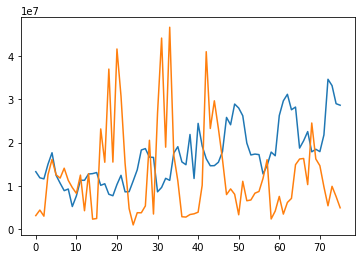

In [16]:
fig = plt.figure()

for frame in [df_ff_mes, df_i_mes]:
    plt.plot(frame['FOB'])
plt.show()

Text(0.5, 0, 'Mes')

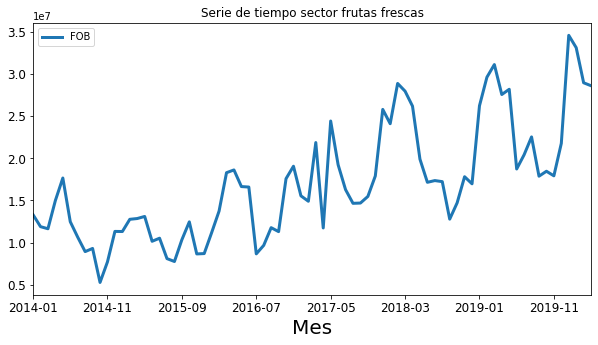

In [17]:
df_ff_mes.plot(x = 'Mes', figsize=(10,5), linewidth=3, fontsize=12, title='Serie de tiempo sector frutas frescas')
plt.xlabel('Mes', fontsize=20)

Text(0.5, 0, 'Mes')

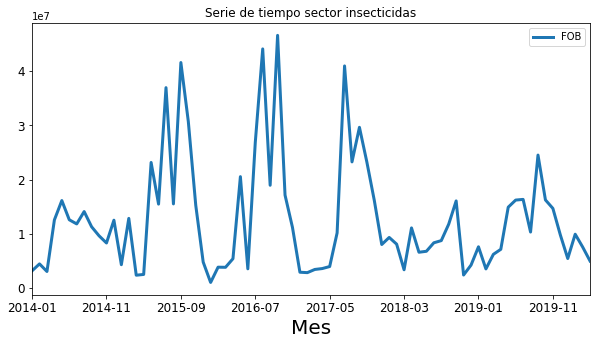

In [18]:
df_i_mes.plot(x = 'Mes',figsize=(10,5), linewidth=3, fontsize=12, title='Serie de tiempo sector insecticidas')
plt.xlabel('Mes', fontsize=20)

# Evaluación de comportamiento de las series

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
df_ff_mes['Mes'] = pd.to_datetime(df_ff_mes['Mes'])
df_i_mes['Mes'] = pd.to_datetime(df_i_mes['Mes'])

In [21]:
df_ff_mes.head()

,Mes,FOB
0,2014-01-01,13308904.93
1,2014-02-01,11894672.01
2,2014-03-01,11646360.80
3,2014-04-01,15006526.37
4,2014-05-01,17669831.21


## Estacionareidad

In [22]:
result = adfuller(df_i_mes['FOB'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.144939
p-value: 0.000011
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


### Conclusión:

Para la serie de insecticidas, el valor p de la prueba de Dickey-Fuller nos permite concluir que no existe evidencia estadística suficiente para rechazar la hipótesis nula de estacionareidad.

In [23]:
result = adfuller(df_ff_mes['FOB'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.168036
p-value: 0.942226
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591


### Conclusión:

A diferencia del resultado para insecticidas, la prueba de Dickey-Fuller para la serie de frutas frescas nos indica que existe evidencia estadística suficiente para rechazar la hipótesis nula de estacionareidad. Por lo tanto, será necesario aplicar a la serie su primera diferencia para volver a realizar la prueba.

In [24]:
result = adfuller(df_ff_mes['FOB'].diff().iloc[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.725971
p-value: 0.000000
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591


### Conclusión:

Finalmente, con la primera diferencia de la serie de frutas frescas, la prueba de Dickey-Fuller nos indica que no existe evidencia estadística suficiente para rechazar la hipótesis nula de estacionareidad. 

## Autocorrelación

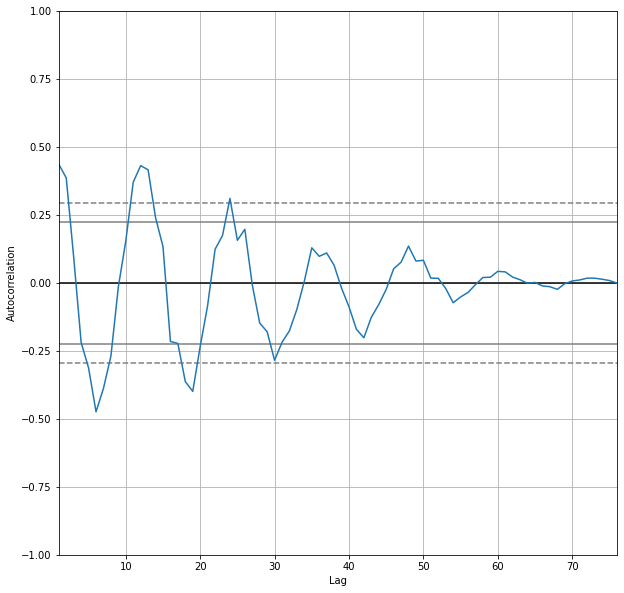

In [25]:
plt.figure(figsize=(10,10))
pd.plotting.autocorrelation_plot(df_i_mes['FOB']);

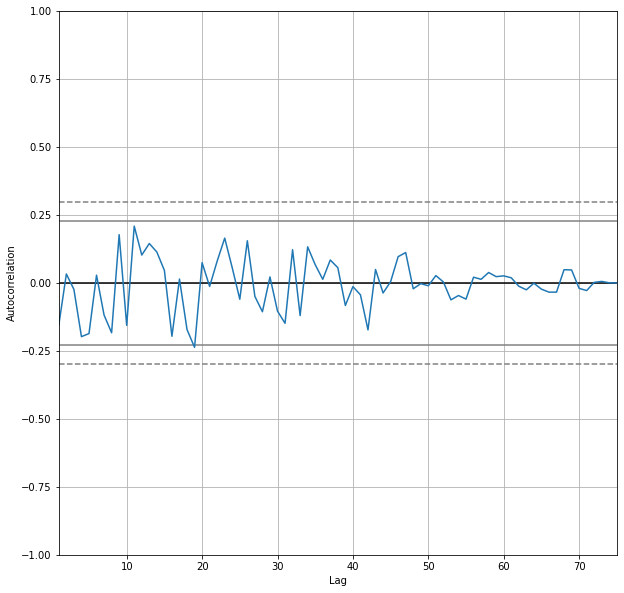

In [26]:
plt.figure(figsize=(10,10))
pd.plotting.autocorrelation_plot(df_ff_mes['FOB'].diff().iloc[1:]);

# Estimación de Modelos

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Insecticidas

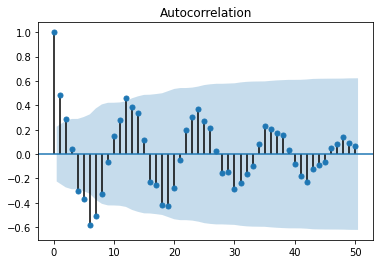

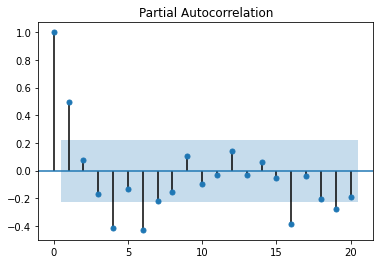

In [28]:
plot_acf(np.log(df_i_mes['FOB']), lags=50);
plot_pacf(np.log(df_i_mes['FOB']), lags=20);

### Comentarios:

Los gráficos de autocorrelación y autocorrelación parcial para las exportaciones de insecticidas nos permiten inferir que la serie posiblemente siga un proceso AR(2)-MA(2)

In [29]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df_i_mes['FOB']), order=(2,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    FOB   No. Observations:                   76
Model:                     ARMA(2, 2)   Log Likelihood                 -68.612
Method:                       css-mle   S.D. of innovations              0.589
Date:                Mon, 22 Jun 2020   AIC                            149.224
Time:                        22:36:46   BIC                            163.209
Sample:                             0   HQIC                           154.813
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0659      0.070    230.976      0.000      15.930      16.202
ar.L1.FOB      1.7173      0.028     62.194      0.000       1.663       1.771
ar.L2.FOB     -0.9712      0.029    -33.415      0.0

### Conclusión:

Es posible observar que el modelo que mejor ajusta los parámetros, con base en las conclusiones teóricas previas es un ARMA(2,2) (tal y como se pensó en un principio). Los valores para los parámetros son estadísticamente significativos para cada uno de ellos, por lo tanto, este sería el modelo ideal.

### Gráfico de los errores de la estimación

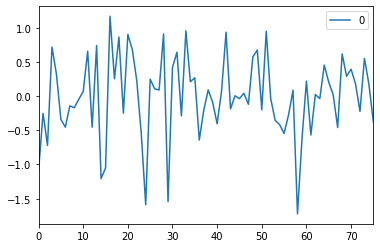

In [30]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

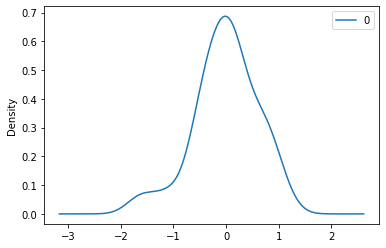

               0
count  76.000000
mean   -0.009563
std     0.602499
min    -1.722646
25%    -0.345096
50%     0.020848
75%     0.339234
max     1.167123


In [31]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

### Test de Shapiro-Wilk para normalidad

In [32]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print('Estadístico=%.3f, p=%.3f' % (stat, p_value))

alpha = 0.05

if p_value > alpha:
    print('No rechazamos la hipótesis nula')
else:
    print('Rechazamos la hipótesis nula')

Estadístico=0.966, p=0.042
Rechazamos laa hipótesis nula


#### Comentario:
* Según los resultados gráficos y los resultados de la prueba de Shapiro-Wilk, es posible concluir que no es posible rechazar la hipótesis nula de normalidad de los errores, ya que el p-valor arrojado por la prueba es de 0.1904

## Rolling Forecast:

Estimación de parámetros para el mejor pronóstico de la serie: *insecticidas*

In [125]:
X = np.log(df_i_mes['FOB']).values
size = int(len(X) * 0.9)
size

68

In [126]:
train, test = X[0:size], X[size:len(X)]

In [127]:
X = np.log(df_i_mes['FOB']).values
p=np.arange(1,7)
q=np.arange(1,4)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

In [128]:
from sklearn.metrics import mean_squared_error

In [37]:
history = [x for x in train]
predictions = list()
errors = list()
for m in range(len(p)):
    for l in range(len(q)):
        for t in range(len(test)):
            model = ARIMA(history, order=(m,1,l))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
        error = mean_squared_error(test, predictions) ** 0.5
        print(m,l,error)
        errors.append(error)
        predictions = list()

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 0 0.6472858698826732
0 1 0.574098173807652
0 2 0.5759387520072273
1 0 0.5841443089237133
1 1 0.5265240645008673
1 2 0.5238042451499221
2 0 0.5583958600560321
2 1 0.6247573858417049
2 2 0.5072388702347826
3 0 0.5574054416008616


C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


3 1 0.5189106105207967


C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KeyboardInterrupt: 

In [129]:
history = [x for x in train]
predictions = list()
errors = list()

In [130]:
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions) ** 0.5
#print(m,l,error)
errors.append(error)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   74
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -81.290
Method:                       css-mle   S.D. of innovations              0.711
Date:                Mon, 22 Jun 2020   AIC                            172.581
Time:                        22:46:18   BIC                            184.101
Sample:                             1   HQIC                           177.176
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.008      0.287      0.775      -0.014       0.018
ar.L1.D.y      0.4713      0.117      4.040      0.000       0.243       0.700
ar.L2.D.y      0.0918      0.117      0.786      0.4

In [132]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print('Estadístico=%.3f, p=%.3f' % (stat, p_value))

alpha = 0.05

if p_value > alpha:
    print('No rechazamos la hipótesis nula')
else:
    print('Rechazamos la hipótesis nula')

Estadístico=0.958, p=0.074
No rechazamos la hipótesis nula


#### Conclusión: los errores guardan normalidad. Los pronósticos que se realicen con el modelo podrían guardar correspondencia con los datos observados

In [133]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions) **0.5
print('Test MSE: %.3f' % error)

Test MSE: 0.553


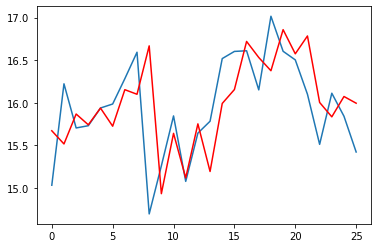

In [134]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### Comentario:

Por otro lado, la modelación que más se ajusta a los datos (y minimiza el MSE) es la de un ARIMA(2,1,1). Lo anterior, teniendo en cuenta que para uno de los periodos se presenta un quiebre estructural que requiere de otras modelaciones para que pueda ser tenido en cuenta.

### En correspondencia con los hallazgos descritos previamente, al transformar el logaritmo a las unidades originales de la variable FOB, se observa que, a pesar de obtener una predicción relativamente buena, las caídas y subidas abruptas en la exportación de insecticidas impiden tener un mejor pronóstico en el dataframe de prueba del modelo

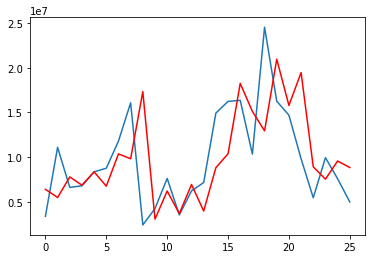

In [135]:
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

## Frutas frescas

### Los gráficos de autocorrelación y autocorrelación parcial de la serie frutas frescas nos permiten inferir que las exportaciones de este renglón de la economía guardan un proceso AR(1)-MA(2)

In [43]:
df_ff_mes.head()

,Mes,FOB
0,2014-01-01,13308904.93
1,2014-02-01,11894672.01
2,2014-03-01,11646360.80
3,2014-04-01,15006526.37
4,2014-05-01,17669831.21


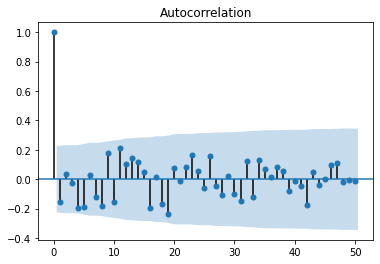

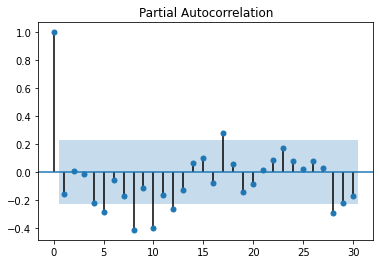

In [44]:
plot_acf(df_ff_mes['FOB'].diff().iloc[1:], lags=50);
plot_pacf(df_ff_mes['FOB'].diff().iloc[1:], lags=30);

In [45]:
Y = np.log(df_i_mes['FOB']).values
p=np.arange(1,5,1)
q=np.arange(2,3,1)
d=np.arange(1,5,1)
size = int(len(X) * 0.66)
train, test = Y[0:size], Y[size:len(Y)]
history = [y for y in train]
predictions = list()
errors = list()
data = []

In [46]:
for m in range(len(p)):
    for n in range(len(q)):
        for o in range(len(d)):
            try:
                for t in range(len(test)):
                    model = ARIMA(history, order=(m,n,o))
                    model_fit = model.fit(disp=0)
                    output = model_fit.forecast()
                    yhat = output[0]
                    predictions.append(yhat)
                    obs = test[t]
                    history.append(obs)
                error = mean_squared_error(test, predictions) ** 0.5
                print(m,n,o,error)
                errors.append(error)
                data.append((m,n,o,error))
                predictions = list()
                history = [x for x in train]
            except:
                print('Error cuando se intenta la combinación '+str(m)+str(n)+str(o))
        
cols=['P','Q','D','error']
result = pd.DataFrame(data, columns=cols)

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 0 0 0.5767803741563485
0 0 1 0.5472218559299593
0 0 2 0.5709359249714339
0 0 3 0.5486269084586334
1 0 0 0.544601526981761
1 0 1 0.5427487960189307
Error cuando se intenta la combinación 102
Error cuando se intenta la combinación 103
2 0 0 0.5417149290553674


C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2 0 1 0.5748998662934098
Error cuando se intenta la combinación 202
Error cuando se intenta la combinación 203
3 0 0 0.5693738646080517
3 0 1 0.6274295836491462
Error cuando se intenta la combinación 302
Error cuando se intenta la combinación 303


#### A pesar de los resultados observados por medio de las gráficas arrojadas por el análisis de la FAS y la FAP, el algoritmo construido para identificar los mejores p,d,q del modelo Arima muestran que el modelo que minimiza el error es una MA(4)

In [47]:
result.sort_values('error')

,P,Q,D,error
6,2,0,0,0.541715
5,1,0,1,0.542749
4,1,0,0,0.544602
1,0,0,1,0.547222
3,0,0,3,0.548627
8,3,0,0,0.569374
2,0,0,2,0.570936
7,2,0,1,0.574900
0,0,0,0,0.576780
9,3,0,1,0.627430


In [48]:
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions) ** 0.5
#print(m,l,error)
errors.append(error)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   75
Model:                     ARMA(0, 4)   Log Likelihood                 -75.424
Method:                       css-mle   S.D. of innovations              0.646
Date:                Mon, 22 Jun 2020   AIC                            162.848
Time:                        22:38:50   BIC                            176.753
Sample:                             0   HQIC                           168.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0528      0.126    127.434      0.000      15.806      16.300
ma.L1.y        0.6079      0.134      4.541      0.000       0.346       0.870
ma.L2.y        0.1777      0.155      1.149      0.2

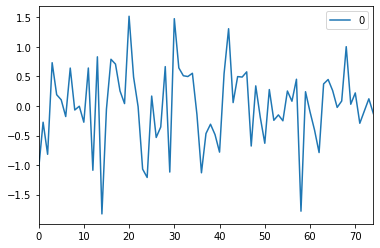

In [49]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

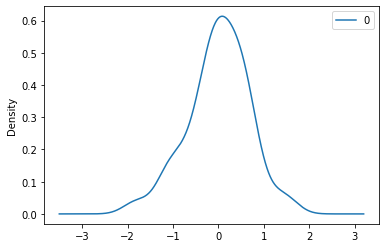

               0
count  75.000000
mean    0.001312
std     0.667782
min    -1.827809
25%    -0.300906
50%     0.040641
75%     0.489863
max     1.519628


In [50]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

### Test de Shapiro-Wilk para normalidad de los errores

In [136]:
stat, p_value = shapiro(residuals)
print('Estadístico=%.3f, p=%.3f' % (stat, p_value))

alpha = 0.05

if p_value > alpha:
    print('No rechazamos la hipótesis nula')
else:
    print('Rechazamos la hipótesis nula')

Estadístico=0.958, p=0.074
No rechazamos la hipótesis nula


#### Comentario:
* Según los resultados gráficos y los resultados de la prueba de Shapiro-Wilk, es posible concluir que no es posible rechazar la hipótesis nula de normalidad de los errores, ya que el p-valor arrojado por la prueba es de 0.1904. Esto indica que los pronósticos realizados por el modelo podrían guardar correspondencia con los valores observados

In [52]:
predictions[-5:]

[array([16.44329462]),
 array([15.58820325]),
 array([15.9904681]),
 array([15.97045465]),
 array([16.07314508])]

### Error cuadrático medio de la estimación

In [53]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions) **0.5
print('Test MSE: %.3f' % error)

Test MSE: 0.534


#### Comentario:

Por los resultados del error cuadrático medio comparados con el útlimo valor pronosticado, se observa que existe un error en el pronóstico de cerca de 3,3%  

### Comparación de las estimaciones con los valores observados

##### 1. Logaritmo 

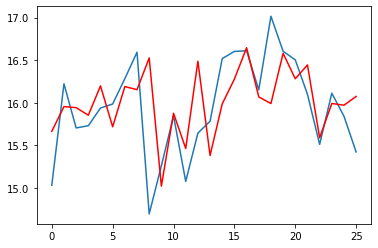

In [54]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

##### 2. FOB transformado a sus unidades originales

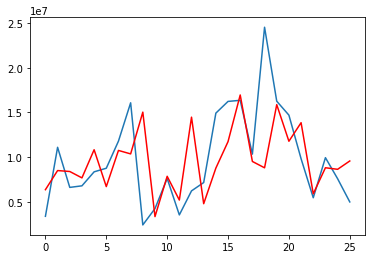

In [55]:
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

#### Conclusión:

Al analizar gráficamente los resultados de las predicciones contra las observaciones  transformados a sus unidades originales, se puede concluir que el modelo es adecuado para pronosticar el valor de las exportaciones. A pesar de lo anterior, el choque en el periodo 18 imposibilitaría tener un mejor pronóstico de la serie.

## Estimación de las exportaciones de frutas frescas con Prophet

* Con el propósito de comparar las predicciones por medio del modelo ARIMA para Frutas Frescas con aquellas arrojadas por Prophet, a continuación se desarrolla la estimación por medio del algoritmo Prophet

### Transformación de la base frutas frescas en un objeto legible para Prophet

In [56]:
df_ff_mes_1 = df_ff_mes.copy()

In [57]:
df_ff_mes_1.columns = ['ds','y']
df_ff_mes_1['ds'] = pd.to_datetime(df_ff_mes_1['ds'])
df_ff_mes_1['y'] = np.log(df_ff_mes_1['y'])

In [58]:
df_ff_mes_1.head()

,ds,y
0,2014-01-01,16.403944
1,2014-02-01,16.291601
2,2014-03-01,16.270504
3,2014-04-01,16.523996
4,2014-05-01,16.687369


### Estimación del modelo inicial con Prophet

In [59]:
#Prophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [60]:
m = Prophet()
m.fit(df_ff_mes_1)
future = m.make_future_dataframe(periods = 20, freq = 'M')
forecast = m.predict(future)
forecast[['ds','yhat', 'yhat_lower','yhat_upper']].iloc[-21:]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
75,2020-04-01,17.155248,16.963622,17.349907
76,2020-04-30,17.096630,16.913677,17.288179
77,2020-05-31,16.835253,16.652571,17.028621
78,2020-06-30,17.012295,16.836787,17.207038
79,2020-07-31,16.981536,16.780795,17.174306
80,2020-08-31,16.900317,16.712320,17.097844
81,2020-09-30,16.958568,16.772763,17.145597
82,2020-10-31,16.695357,16.519803,16.878905
83,2020-11-30,16.823454,16.613459,16.994292
84,2020-12-31,17.376441,17.182567,17.561593


#### Armonización de las fechas arrojadas por Prophet con las de la base DANE 

In [61]:
# Sumarle un día a las fechas sacadas con future después de hacer el forecast

from datetime import datetime
from datetime import timedelta
forecast['ds'].iloc[-20:] =forecast['ds'].iloc[-20:] + timedelta(days=1)

In [62]:
forecast['ds'].iloc[-21:]

75   2020-04-01
76   2020-05-01
77   2020-06-01
78   2020-07-01
79   2020-08-01
80   2020-09-01
81   2020-10-01
82   2020-11-01
83   2020-12-01
84   2021-01-01
85   2021-02-01
86   2021-03-01
87   2021-04-01
88   2021-05-01
89   2021-06-01
90   2021-07-01
91   2021-08-01
92   2021-09-01
93   2021-10-01
94   2021-11-01
95   2021-12-01
Name: ds, dtype: datetime64[ns]

#### Estimación del error cuadrático medio

In [63]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(df_ff_mes_1['y'], forecast['yhat'].iloc[0:76]) **0.5
print('Test MSE: %.3f' % error)

Test MSE: 0.148


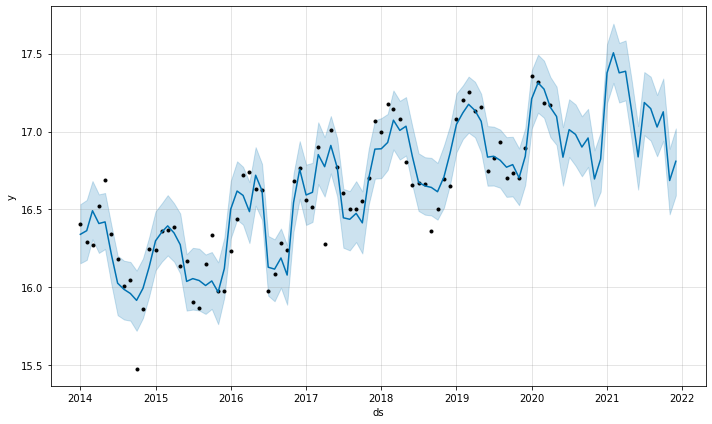

In [64]:
fig1 = m.plot(forecast)

### Comentario:

Al transformar las predicciones de Prophet a las unidades originales de la variable FOB, se observa que estas guardan correspondencia con los valores observados mes a mes.

Debido al incremento gradual en la varianza de la variable, se observa que los pronósticos realizados por Prophet memorizan esta propiedad y la acentúan a lo largo de los próximos periodos pronosticados.

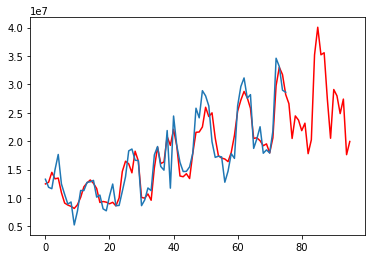

In [65]:
plt.plot(np.exp(forecast['yhat']), color='red')
plt.plot(np.exp(df_ff_mes_1['y']))
plt.show()

#### Rolling forecast usando Prophet

Para este ejercicio se utilizará el 66% de la base total como la base de entrenamiento y los valores restantes serán usados para la prueba del modelo

In [66]:
X = df_ff_mes_1.values
size = int(len(X) * 0.66)
size
train, test = X[0:size], X[size:len(df_ff_mes)]

In [67]:
test =pd.DataFrame(test)
test.columns = ['ds', 'y']
test['ds'] = pd.to_datetime(test['ds'])

In [68]:
train =pd.DataFrame(train)
train.columns = ['ds', 'y']
train['ds'] = pd.to_datetime(train['ds'])

In [69]:
test

,ds,y
0,2018-03-01,17.147
1,2018-04-01,17.0812
2,2018-05-01,16.8065
3,2018-06-01,16.658
4,2018-07-01,16.67
5,2018-08-01,16.6627
6,2018-09-01,16.364
7,2018-10-01,16.5052
8,2018-11-01,16.696
9,2018-12-01,16.6475


### Con este loop, se predicen los próximos seis periodos con rolling forecast

In [72]:
prediccion = pd.DataFrame(columns = ['ds', 'yhat', 'yhat_lower','yhat_upper'])
### Se corre con range=1. Sin embargo, inicialmente se corrió para seis periodos.
for l in range(1):
    for t in range(len(test)):
        model = Prophet(n_changepoints = 1)
        model_fit = model.fit(train)
        future = model.make_future_dataframe(periods = l , freq = 'M')
        forecast = model.predict(future)
        forecast['ds'].iloc[-l:] =forecast['ds'].iloc[-l:] + timedelta(days=1)
        #print(len(forecast))
        obs = pd.DataFrame(test[['ds','y']].iloc[:l])
#print(obs)
prediccion = prediccion.append(forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [73]:
prediccion.tail()

,ds,yhat,yhat_lower,yhat_upper
45,2017-10-02,16.485885,16.266437,16.701340
46,2017-11-02,16.763776,16.550303,16.969709
47,2017-12-02,17.002668,16.786557,17.215112
48,2018-01-02,17.031668,16.820331,17.250336
49,2018-02-02,17.100351,16.895771,17.321622


### Error cuadrático medio de la estimación

In [74]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test['y'], prediccion['yhat'].iloc[0:26]) **0.5
print('Test MSE: %.3f' % error)

Test MSE: 0.740


#### Comentario:
* Al comparar el error cuadrático medio con la última estimación del dataframe predicción, se calcula un error aproximado de 4,2% en el pronóstico 

#### Los resultados del pronóstico de Prophet guardan las propiedades observadas de las exportaciones.

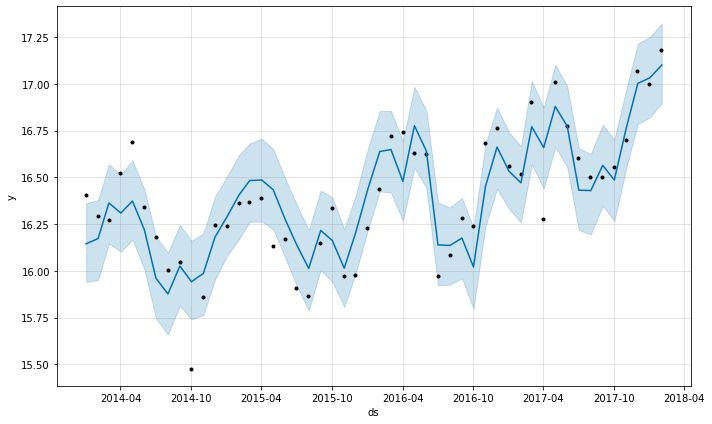

In [75]:
fig2 = model.plot(forecast)

# Análisis departamental de la exportaciones de frutas frescas: casos de Bogotá y Antioquia

## Departamentos con mayor valor FOB de exportaciones en el sector de insecticidas y frutas frescas

In [76]:
df_i_a = df_i.groupby(['Departamento']).sum().reset_index().sort_values(by='FOB', ascending=False).head(5)
df_ff_a = df_ff.groupby(['Departamento']).sum().reset_index().sort_values(by='FOB', ascending=False).head(5)

class color:
   BOLD = '\033[1m'
   END = '\033[0m'

print(color.BOLD + 'Exportaciones de Insecticidas' + color.END)
display(df_i_a)
print(color.BOLD + 'Exportaciones de Frutas frescas' + color.END)
display(df_ff_a)

Exportaciones de Insecticidas


,Departamento,PA,FOB
1,Atlántico,2879532949014,7.983778e+08
3,Bolívar,3172825203930,1.339858e+08
2,Bogotá,4563053628431,2.386731e+07
7,Cundinamarca,959841534295,4.387349e+06
13,Valle del Cauca,1474033058282,4.369480e+06


Exportaciones de Frutas frescas


,Departamento,PA,FOB
0,Antioquia,4461796285250,6.540202e+08
3,Bogotá,8427758105480,1.960820e+08
9,Cundinamarca,5706647785690,1.802963e+08
18,Risaralda,424670744360,7.816943e+07
23,Valle del Cauca,987726344410,5.727502e+07


### Conclusión 
En el sector de insecticidas el departamento con mayor valor de exportaciones es el Atlántico seguido de Bolivar. Mientras, los departamento que más exportan productos en el sector de frutas frescas son Antioquia y Bogotá.  


## Creación de series tiempo por departamento de mayor exportación en el sector de frutas frescas

In [77]:
df_ff_cols_plot = ['Antioquia', 'Bogotá']
df_ff_An_Bo = df_ff[df_ff.Departamento.isin(df_ff_cols_plot)].drop(columns = ['Pais','Year'], axis = 1).set_index('Mes')
df_ff_An_Bo = df_ff_An_Bo.pivot_table(values='FOB',index = 'Mes' ,columns=['Departamento'])
df_ff_An_Bo

Departamento,Antioquia,Bogotá
Mes,,
2014-01,167857.109333,14568.017523
2014-02,159612.060698,15893.333840
2014-03,131329.352093,17645.473258
2014-04,139881.830600,27742.712764
2014-05,320223.630303,22097.379776
2014-06,176339.172600,13250.775344
2014-07,142126.779318,17752.564407
2014-08,125674.182250,15137.581824
2014-09,116480.524545,10260.863562


In [78]:
df_ff_An_Bo.isna().sum()

Departamento
Antioquia    0
Bogotá       0
dtype: int64

No hay datos NA en las series de tiempo de exportaciones por los departamentos de Antioquia, ni en Bogotá para el sector de frutas frescas. 

## BD Sieries de tiempo frutas frescas

In [79]:
#Sector frustas frecas
#dff1= df_i_At_Bo.copy()
#dff1.columns=['Antioquia', 'Bogotá']
dff1= df_ff_An_Bo.copy()
#dff1['new'] = (dff1['Antioquia'].diff()/dff1['Antioquia'])
dff1

Departamento,Antioquia,Bogotá
Mes,,
2014-01,167857.109333,14568.017523
2014-02,159612.060698,15893.333840
2014-03,131329.352093,17645.473258
2014-04,139881.830600,27742.712764
2014-05,320223.630303,22097.379776
2014-06,176339.172600,13250.775344
2014-07,142126.779318,17752.564407
2014-08,125674.182250,15137.581824
2014-09,116480.524545,10260.863562


## Análisis series de tiempo para el sector de Frutas Frescas

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Gráfica serie de tiempo frutas frescas Antioquia

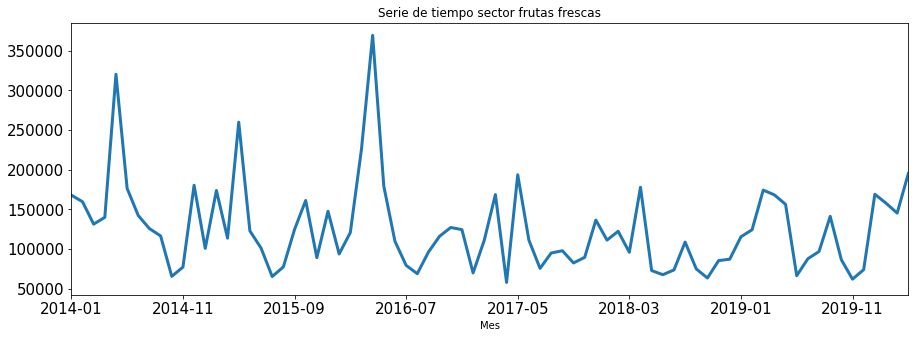

In [81]:
dff1['Antioquia'].plot(figsize=(15,5), linewidth=3, fontsize=15, title='Serie de tiempo sector frutas frescas')
#dff1['Antioquia']plt.xlabel('Month', fontsize=15)

**Departamento Antioquia:** En la primera gráfica se observa que las exportaciones en el sector de frutas frescas tienen un comportamiento similar entre el año 2014 hasta finales del 2016, donde el valor FOB se mantiene dentro de un rango de 50 mil hasta incluso 360 mil y con una estacionalidad cada dos o tres meses.
Sin embargo, a partir del 2017 el valor máximo de las exportaciones no ha superado los 200 mil y la estacionalidad de las mismas ya no estan clara.  

### Gráfica serie de tiempo frutas frescas Bogotá

Text(0.5, 0, 'Month')

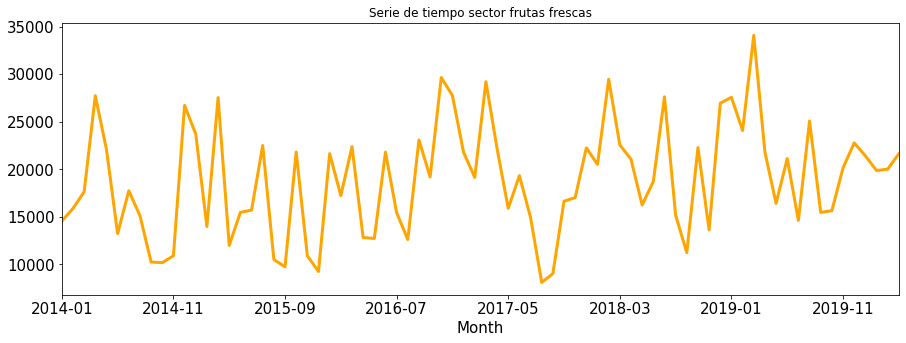

In [82]:
dff1['Bogotá'].plot(figsize=(15,5), linewidth=3, fontsize=15, title='Serie de tiempo sector frutas frescas', color='orange')
plt.xlabel('Month', fontsize=15)

**Bogotá:** Se observa que el valor FOB de las exportaciones oscilan entre 8 mil y 34mil desde el 2014 hasta el 2020 y la varianza parece permanecer constante en el tiempo. 

### Promedio movil 
#### Antioquia

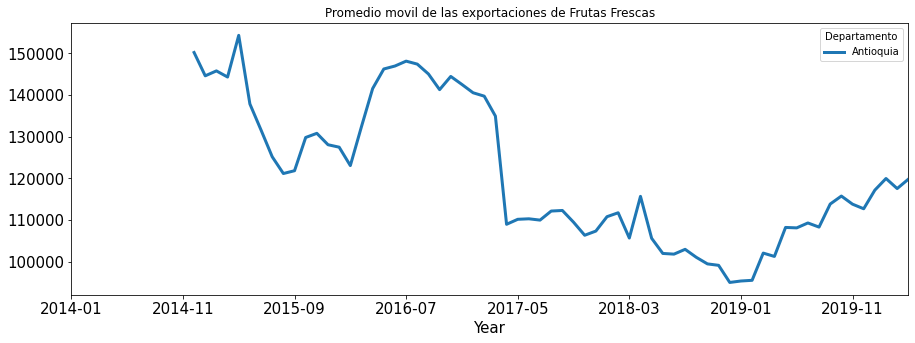

In [83]:
Tend_ff = dff1[['Antioquia']]
Tend_ff.rolling(12).mean().plot(figsize=(15,5), linewidth=3, fontsize=15, title='Promedio movil de las exportaciones de Frutas Frescas')
plt.xlabel('Year', fontsize=15);

**Departamento Antioquia:** La gráfica del promedio movil de 12 periodos, muestra que las exportaciones del depto. de Antioquia tuvieron una tendencia negativa hasta finales del 2018 y a partir del 2019, el promedio de las exportaciones cambio de tendencia y tuvo un crecimiento constante en el último año.

#### Bogotá

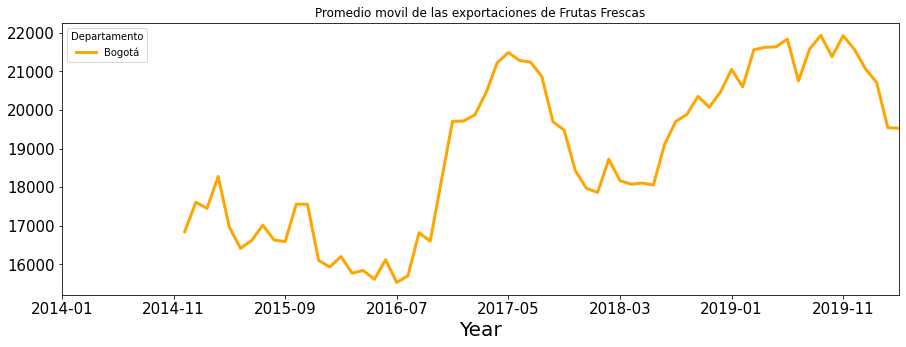

In [84]:
Tend_ff = dff1[['Bogotá']]
Tend_ff.rolling(12).mean().plot(figsize=(15,5), linewidth=3, fontsize=15, title='Promedio movil de las exportaciones de Frutas Frescas', color='orange')
plt.xlabel('Year', fontsize=20);

**Bogotá:** La gráfica del promedio movil de 12 periodos, muestra que en general las exportaciones la ciudad de Bogotá han crecido a lo largo del tiempo, sin embargo este no ha sido constante y por lo tanto se pueden ver caidas en el valor de las exportaciones como en el año 2017 y a finales del 2019. 

### Test de Duckey-Fuller para probar estacionaridad 
#### Antioquia

In [85]:
from statsmodels.tsa.stattools import adfuller

In [86]:
#DUCKEY-FULLER PARA ANTIOQUIA
result = adfuller(dff1['Antioquia'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.109646
p-value: 0.000000
Critical Values:
	1%: -3.521
	5%: -2.901
	10%: -2.588


#### Bogotá

In [87]:
#DUCKEY-FULLER PARA BOGOTÁ
result2 = adfuller(dff1['Bogotá'])
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical Values:')
for key, value in result2[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.792819
p-value: 0.000000
Critical Values:
	1%: -3.521
	5%: -2.901
	10%: -2.588


#### Conclusiones prueba Duckey-Fuller
H0: serie es estacionaria

H1: serie no es estacionaria

De acuerdo con los resultados de la prueba de Duckey-Fuller, tanto la serie de exportaciones del departamento de Antioquia, como la de la ciudad de Bogotá, son estacionarias. Dado que a un nivel de confianza del 95% no hay evidencia estadística suficiente para rechazar la hipótesis nula. Por lo tanto, los datos son válidos para realizar un análisis de pronóstico con series de tiempo.

### Patrones de estacionalidad 

A continuación, se grafican las series diferenciadas en primer orden para identificar patrones de estacionalidad. 


#### Antioquia

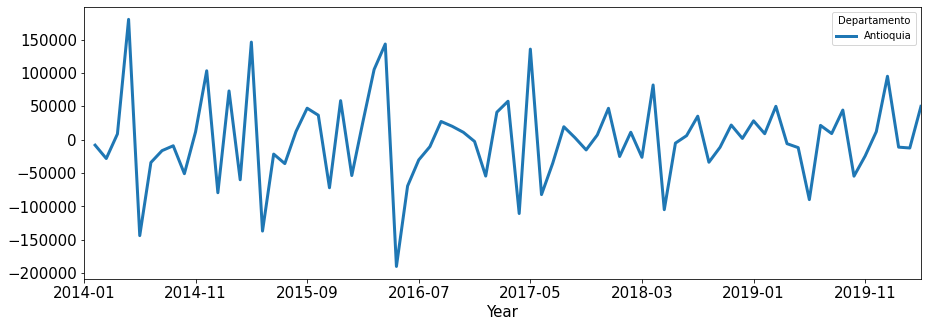

In [88]:
dff1[['Antioquia']].diff().plot(figsize=(15,5), linewidth=3, fontsize=15) #A cada observación se le resta la observación anterior (orden 1)
plt.xlabel('Year', fontsize=15);

#### Bogotá

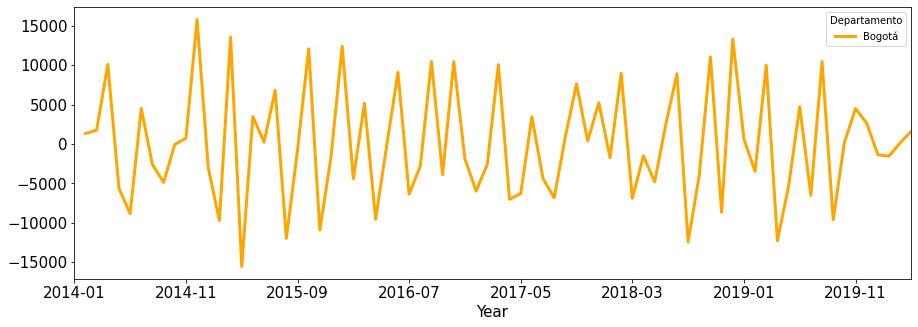

In [89]:
dff1[['Bogotá']].diff().plot(figsize=(15,5), linewidth=3, fontsize=15, color="orange") #A cada observación se le resta la pbservación anterior (orden 1)
plt.xlabel('Year', fontsize=15);

Para el departamento de Antioquia sobresale un pico en el valor de las exportaciones cada 12 meses, aproximadamente en marzo, y picos más pequeños a los largo del año- Mientras que la serie de Bogotá no sobresale ningún pico en especial, sino que los valores de exportaciones tienden a mantenerse fijos en un rango de valores.  

### Correlación entre el valor de las exportaciones el departamento de Antioquia y la ciudad de Bogotá  

In [90]:
dff1.diff(1).corr()

Departamento,Antioquia,Bogotá
Departamento,,
Antioquia,1.000000,-0.078567
Bogotá,-0.078567,1.000000


In [91]:
Bogota= dff1['Bogotá']
#Bogota
Antioquia= dff1['Antioquia']
Antioquia

Mes
2014-01    167857.109333
2014-02    159612.060698
2014-03    131329.352093
2014-04    139881.830600
2014-05    320223.630303
2014-06    176339.172600
2014-07    142126.779318
2014-08    125674.182250
2014-09    116480.524545
2014-10     65474.683000
2014-11     77104.248269
2014-12    180342.667742
2015-01    100764.253600
2015-02    173789.463478
2015-03    113638.370196
2015-04    259866.288235
2015-05    122814.307600
2015-06    101174.347818
2015-07     65264.925319
2015-08     77409.960784
2015-09    124541.079400
2015-10    161168.952791
2015-11     89055.218431
2015-12    147511.630909
2016-01     93712.214000
2016-02    120769.045932
2016-03    225933.744444
2016-04    369280.591111
2016-05    179195.605738
2016-06    109709.649605
               ...      
2017-11     89445.279070
2017-12    136436.670532
2018-01    111197.065000
2018-02    122298.356273
2018-03     95835.620917
2018-04    177803.808333
2018-05     72812.196328
2018-06     67589.056514
2018-07     73572.742

#### Estadístico de Pearson para probar correlación entre depto. Antioquia y la ciudad de Bogotá

In [92]:
from scipy import stats
Bogota = [x for x in Bogota]
Antioquia= [y for y in Antioquia]
stats.pearsonr(Bogota,Antioquia)

(0.03184532858041253, 0.7847845608904664)

Ho: No hay correlación 

Ha: Hay correlación

De acuerdo con los resultados de la prueba de pearson, se puede concluir que no hay correlación entre el valor de las exportaciones del departamento de Antioquia y la ciudad de Bogotá. Dado que a un nivel de significancia del 95%, no hay evidencia estadística suficiente para rechazar H0. Por lo tanto, son eventos independientes, ya que el comportamiento de una no infiere en la otra.



### Autocorrelación
#### Antioquia

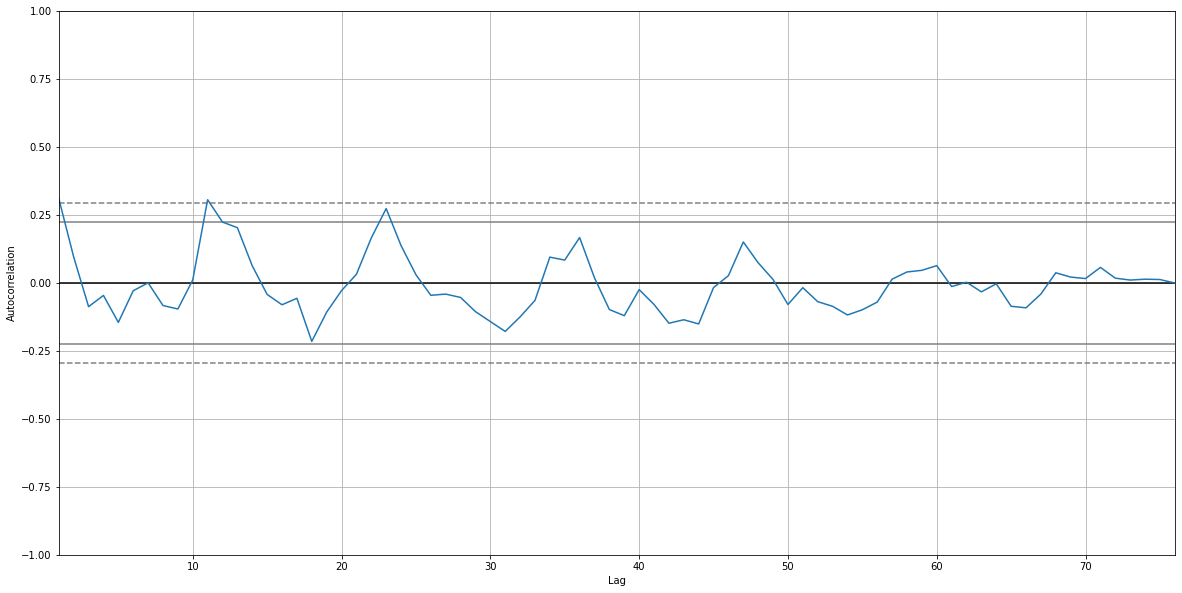

In [93]:
plt.figure(figsize=(20,10));
pd.plotting.autocorrelation_plot(dff1['Antioquia'])

#### Bogotá

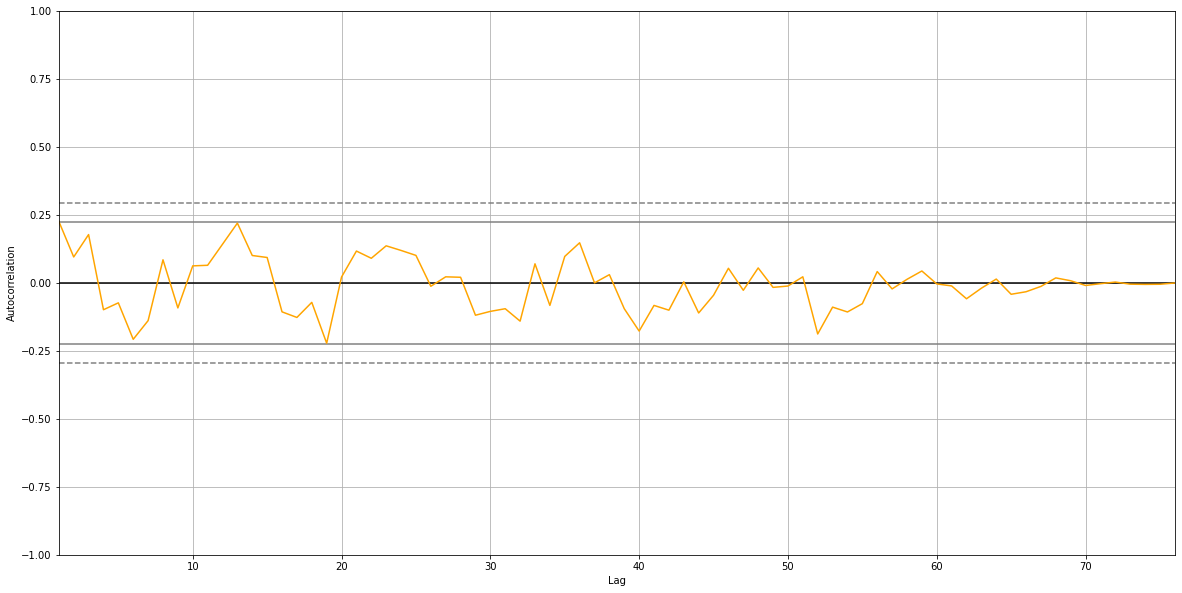

In [94]:
plt.figure(figsize=(20,10));
pd.plotting.autocorrelation_plot(dff1['Bogotá'], color='orange')

## Autocorrelación y autocorrelaciones parciales Antioquia

In [95]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

### Autocorrelación

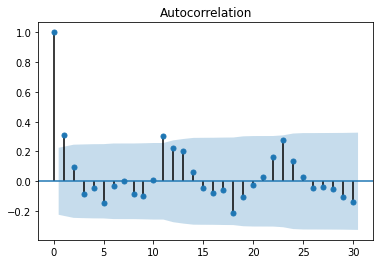

In [96]:
plot_acf(dff1[['Antioquia']], lags=30);

En la gráfica anterior se observa que las exportaciones del departamento de Antioquia tienen una autocorrelación significativa en el primer factor, es decir se puede aplicar un modelo AR(1) para realizar las predicciones.

### Autocorrelaciones Parciales

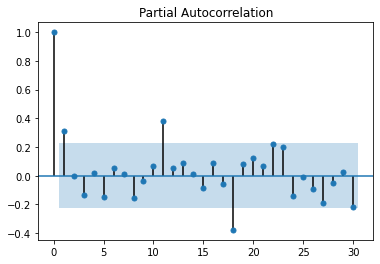

In [97]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dff1[['Antioquia']], lags=30);

En la gráfica anterior se observa que las exportaciones del departamento de Antioquia tienen una autocorrelación significativa en el primer factor, es decir se puede aplicar un modelo AR(1) para realizar las predicciones.

## Autocorrelación y autocorrelaciones parciales Bogotá
### Autocorrelación

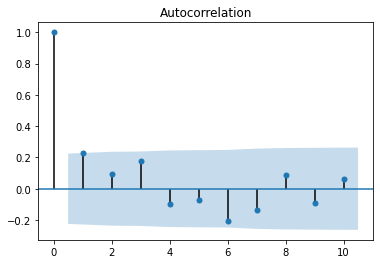

In [98]:
plot_acf(dff1[['Bogotá']], lags=10);

En la gráfica anterior se observa que las exportaciones de Bogotá tienen una autocorrelación significativa en el primer factor, es decir se puede aplicar un modelo AR(1) para realizar las predicciones.

### Autocorrelaciones Parciales

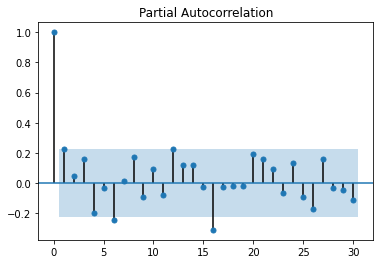

In [99]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dff1[['Bogotá']], lags=30);

En la gráfica anterior se observa que las exportaciones de Bogotá tienen una autocorrelación significativa en el primer, sexto y dieciseisavo, por lo tanto, para la predicción es posible tomar un modelo MA(1), MA(6) o MA(16) para la predicción. Más adelante, se valida cada uno de ellos.

## ARIMA Antioquia

### ARIMA loop mínimiza MSE

In [100]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

p = np.arange(1,5)
#q = 0


X = dff1[['Antioquia']].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
errors = list()


for m in range(len(p)):
    for t in range(len(test)):
        model = ARIMA(history, order=(m,0,1))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    error = mean_squared_error(test, predictions) ** 0.5
    print(m,0,1,error)
    errors.append(error)
    predictions = list()
    history = [x for x in train]

0 0 1 41503.234653649844
1 0 1 40706.55193863004
2 0 1 40323.48847863575
3 0 1 41969.562406746714


El modelo que minimiza el MSE es un modelo AR(2) y MA(1), con un MSE de 40626. La modelación que más se ajusta a los datos (y minimiza el MSE) es la de un ARMA(2,1). Con un MSE de 40410.

### ARIMA sin loop

In [101]:
X = dff1[['Antioquia']].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

from statsmodels.tsa.arima_model import ARIMA
#fit model
model = ARIMA(X, order=(2,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   76
Model:                     ARMA(2, 1)   Log Likelihood                -934.108
Method:                       css-mle   S.D. of innovations          52632.838
Date:                Mon, 22 Jun 2020   AIC                           1878.216
Time:                        22:42:24   BIC                           1889.870
Sample:                             0   HQIC                          1882.873
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.25e+05   9152.851     13.655      0.000    1.07e+05    1.43e+05
ar.L1.y       -0.3978      0.295     -1.347      0.182      -0.977       0.181
ar.L2.y        0.2858      0.127      2.254      0.0

Para el modelo ARIMA(2,0,1) se puede ver que los coeficientes AR(2) y MA(1) son significativos, ya que su pvalue es menor a un 5%. Este modelo tiene un MSE de 40410

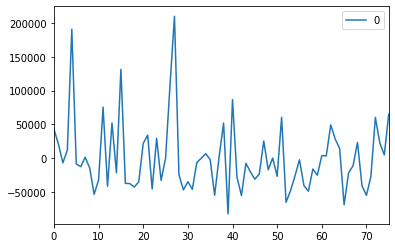

In [102]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

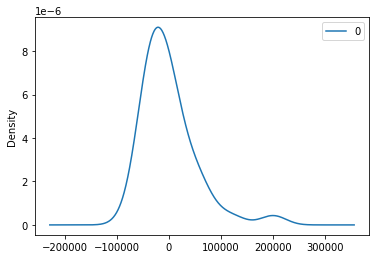

                   0
count      76.000000
mean      334.752424
std     53011.572316
min    -82220.882443
25%    -34663.627282
50%     -9717.909890
75%     22206.844677
max    209973.604960


In [103]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [104]:
from scipy import stats
prueba= stats.normaltest(residuals)
prueba

NormaltestResult(statistic=array([37.12566263]), pvalue=array([8.67490629e-09]))


Ho: La variable se distribuye normal

Ha: La variable no se distribuye normal

De acuerdo con los resultados de la prueba D’Agostino and Pearson’s, a un nivel de significancia del 95% se rechaza la Ho, y por lo tanto se puede concluir que los errores de la serie no se distribuyen normal. Adicionalmente, se observa que la media de los errores en la gráfica es diferente de 0 y su desviación estandar es diferente de 1, por lo tanto los datos no se comportan como ruido blanco.

### Como se observa en los resultados el mejor modelo para predecir es Arima (2,0,1), con un MSE de 40410. Sin embargo, dado que los errores no se distribuyen normal, este modelo no es válido para predecir dado que los errores no se comportan como ruido blanco. 

## Prophet Antioquia

In [145]:
df_i2=df_i[['Mes','Departamento','FOB']]
df_i2=df_i2[df_i2.Departamento.isin(['Antioquia'])]
df_i2.columns=['ds','Departamento','y']
df_i2=df_i2[['ds','y']]
df_i2['y'].astype(np.float64)
df_i2['y']=df_i2['y'].astype(np.float64)

In [106]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot


m = Prophet()
m.fit(df_i2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [107]:
future = m.make_future_dataframe(periods=6, freq='M')
future.tail()

,ds
75,2020-04-30
76,2020-05-31
77,2020-06-30
78,2020-07-31
79,2020-08-31


In [108]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2014-03-01,7467.901105,-12830.426831,27203.688887
1,2014-04-01,4620.729773,-16038.727267,24171.247200
2,2014-06-01,7101.631871,-12240.368171,28050.384189
3,2014-08-01,14417.159192,-5171.134908,34215.011754
4,2014-08-01,14417.159192,-6825.338445,33685.435742
5,2014-09-01,26496.963986,6300.027908,47209.549084
6,2014-10-01,10046.767570,-9340.334160,30059.308771
7,2014-12-01,16851.120241,-2443.729537,36726.027555
8,2014-12-01,16851.120241,-2684.764783,35888.718924
9,2015-01-01,15078.254972,-4572.907092,34220.206635


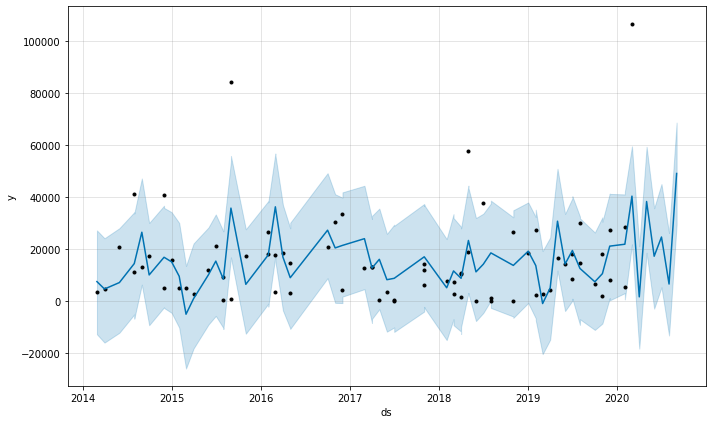

In [109]:
fig1 = m.plot(forecast)

In [110]:
metric_df = forecast.set_index('ds')[['yhat']].join(df_i2.set_index('ds').y)
metric_df.dropna(inplace=True)
error= mean_squared_error(metric_df.y, metric_df.yhat)**0.5

print('Test MSE: %.3f' % error)

Test MSE: 15233.620


In [111]:
df_i2=df_i[['Mes','Departamento','FOB']]
df_i2=df_i2[df_i2.Departamento.isin(['Antioquia'])]
df_i2.columns=['ds','Departamento','y']
df_i2=df_i2[['ds','y']]
df_i2['y'].astype(np.float64)
df_i2['y']=df_i2['y'].astype(np.float64)

### En este caso la librería prophet se obtiene un MSE de 15233, el cual es inferior al ARIMA(2,0,1). 

## ARIMA Bogotá

### ARIMA loop mínimiza MSE

In [112]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

p = np.arange(1,7)
#q = 0


X = dff1[['Bogotá']].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
errors = list()

#for l in range(len(q)):
for m in range(len(p)):
    for t in range(len(test)):
        model = ARIMA(history, order=(m,0,1))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    error = mean_squared_error(test, predictions) ** 0.5
    print(m,0,1,error)
    errors.append(error)
    predictions = list()
    history = [x for x in train]

0 0 1 5477.060414357347
1 0 1 5550.971706298949


C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



2 0 1 5485.711819769918
3 0 1 5269.167303409699
4 0 1 5558.509172757218
5 0 1 5753.597735123751


La modelación que más se ajusta a los datos (y minimiza el MSE) es la de un ARIMA(2,0,1).

### Arima sin loop

In [113]:
from statsmodels.tsa.arima_model import ARIMA
#fit model

X = dff1[['Bogotá']].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

model = ARIMA(train, order=(2,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   50
Model:                     ARMA(2, 1)   Log Likelihood                -504.180
Method:                       css-mle   S.D. of innovations           5789.213
Date:                Mon, 22 Jun 2020   AIC                           1018.359
Time:                        22:43:24   BIC                           1027.919
Sample:                             0   HQIC                          1022.000
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         1.8e+04   1020.522     17.633      0.000     1.6e+04       2e+04
ar.L1.y       -0.4420      0.401     -1.101      0.276      -1.228       0.344
ar.L2.y        0.0826      0.190      0.435      0.6

In [114]:
from scipy import stats
prueba= stats.normaltest(residuals)
prueba

NormaltestResult(statistic=array([37.12566263]), pvalue=array([8.67490629e-09]))

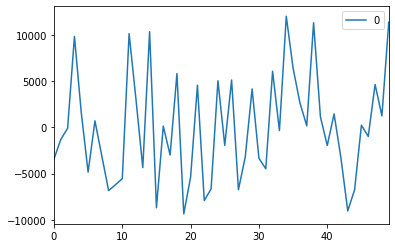

In [115]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

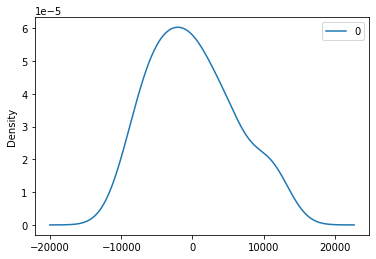

                  0
count     50.000000
mean      11.177534
std     5849.866989
min    -9353.135020
25%    -4440.899160
50%     -217.005727
75%     4461.157451
max    12014.998498


In [116]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Ho: La variable se distribuye normal

Ha: La variable no se distribuye normal

De acuerdo con los resultados de la prueba D’Agostino and Pearson’s, a un nivel de significancia del 95% se rechaza la Ho, y por lo tanto se puede concluir que los errores de la serie no se distribuyen normal. Adicionalmente, se observa que la media de los errores en la gráfica es diferente de 0 y su desviación estandar es diferente de 1, por lo tanto los datos no se comportan como ruido blanco.

# Análisis de las exportaciones a países seleccionados

Se busco elegir los paises con más exportaciones en cada producto en un principio. Sin embargo, debido a que encontramos varios valores vacios en las series decidimos trabajar aquellos que no tenían vacios y además eran representativos


In [148]:
df_i_a = df_i.groupby(['Pais']).sum().reset_index().sort_values(by='FOB', ascending=False).head(5)
df_ff_a = df_ff.groupby(['Pais']).sum().reset_index().sort_values(by='FOB', ascending=False).head(5)

class color:
   BOLD = '\033[1m'
   END = '\033[0m'

print(color.BOLD + 'Exportaciones de Insecticidas' + color.END)
display(df_i_a)
print(color.BOLD + 'Exportaciones de Frutas frescas' + color.END)
display(df_ff_a)

Exportaciones de Insecticidas


,Pais,PA,FOB
5,Brasil,179018620800,5.106490e+08
26,México,559910245240,1.156063e+08
1,Argentina,384698848760,1.101014e+08
12,Ecuador,2532917845745,5.264958e+07
31,Perú,1496896273354,5.013548e+07


Exportaciones de Frutas frescas


,Pais,PA,FOB
53,Países Bajos,2215527993600,4.335130e+08
26,Estados Unidos,924460723290,2.370975e+08
59,Reino Unido,1172465431370,1.985045e+08
10,Bélgica,699449711000,7.561823e+07
25,España,1944166786480,7.317714e+07


In [149]:
df_ff_Al_Hk = df_ff.drop(columns = ['Departamento','Year'], axis = 1).set_index('Mes')
df_ff_Al_Hk = df_ff_Al_Hk.pivot_table(values='FOB',index = 'Mes' ,columns=['Pais'])
df_ff_Al_Hk.isna().sum().sort_values(ascending=True)

Pais
Alemania                   0
Hong Kong                  0
Panamá                     0
Guadalupe                  0
Francia                    0
Estados Unidos             0
España                     0
Emiratos Árabes Unidos     0
Países Bajos               0
Portugal                   0
Reino Unido                0
Italia                     0
Bélgica                    0
Suiza                      0
Aruba                      0
Rusia                      0
Brasil                     0
Canadá                     0
Chile                      1
Ecuador                    1
Puerto Rico                3
Martinica                  4
Guatemala                 13
Curazao                   14
China                     18
Singapur                  19
Costa Rica                23
Guayana Francesa          24
Eslovenia                 41
Suecia                    43
                          ..
Perú                      62
Bolivia                   63
Australia                 63
Noruega  

In [150]:
df_ff_cols_plot = ['Alemania', 'Hong Kong']
df_ff_Al_Hk = df_ff[df_ff.Pais.isin(df_ff_cols_plot)].drop(columns = ['Departamento','Year'], axis = 1).set_index('Mes')
df_ff_Al_Hk = df_ff_Al_Hk.pivot_table(values='FOB',index = 'Mes' ,columns=['Pais']).fillna(0)
df_ff_Al_Hk

Pais,Alemania,Hong Kong
Mes,,
2014-01,29655.832500,3382.056000
2014-02,30801.018500,11438.650000
2014-03,38224.610870,27832.976667
2014-04,55361.476111,26133.076000
2014-05,76600.593478,7151.946667
2014-06,29467.910417,13174.035000
2014-07,48470.557143,2118.898000
2014-08,50749.414000,5734.063333
2014-09,50860.523810,22214.988000


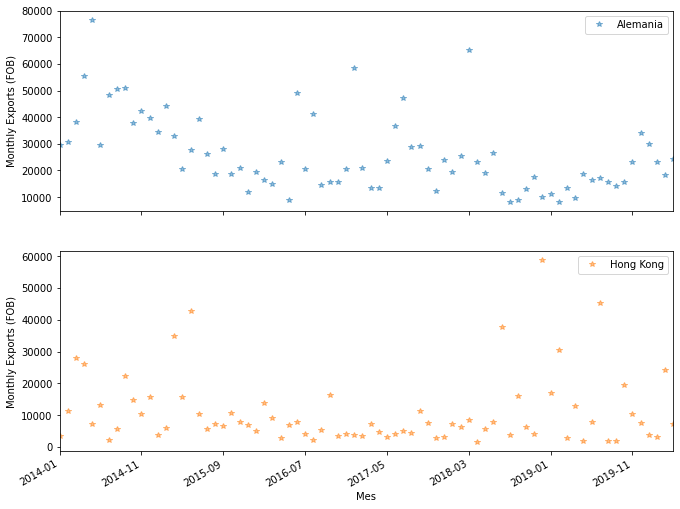

In [151]:
pd.plotting.register_matplotlib_converters()
axes = df_ff_Al_Hk[df_ff_cols_plot].plot(marker='*', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Monthly Exports (FOB)')

## Análisis de Series de Tiempo

In [152]:
%matplotlib inline

In [153]:
dff=df_ff_Al_Hk[df_ff_cols_plot]

Text(0.5, 0, 'Month')

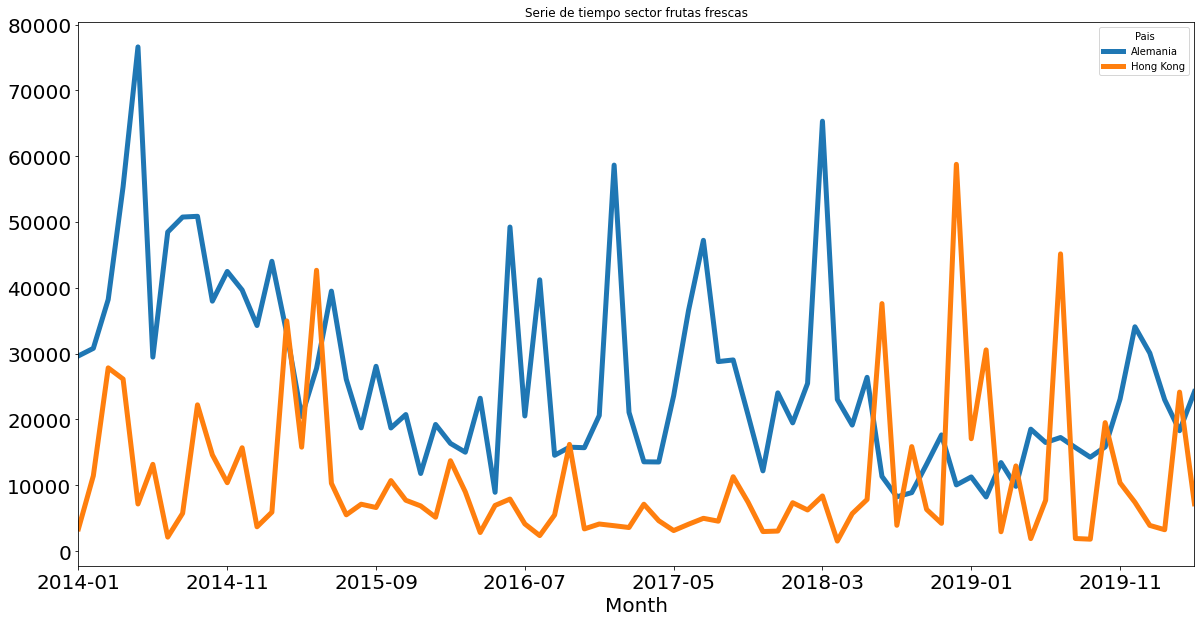

In [154]:
dff.plot(figsize=(20,10), linewidth=5, fontsize=20, title='Serie de tiempo sector frutas frescas')
plt.xlabel('Month', fontsize=20)

**Alemania:** En esta primera gráfica se observa que las exportaciones en el sector de frutas frescas tienen un comportamiento similar entre el año 2014 hasta finales del 2018, donde el valor FOB se mantiene dentro de un rango de 10 mil hasta incluso 60 mil y con una estacionalidad cada tres meses.
Sin embargo, a partir de mitad del 2018 las exportaciones se han manteido por debajo de los 20 mil con un outlier a finales del 2019 y parece que están volviendo a subir en el año 2020.

**Panamá:** En esta primera gráfica se observa que las exportaciones en el sector de Insecticidas tienen un comportamiento fluctuante. En el cual, se observa que cada dos meses hay grandes picos de exportación que están entre los 150mil y los 300mil. Y en los meses intermedios se observan valles que estan alrededor de los 25mil

**Ecuador:** Se observa que el valor FOB de las exportaciones oscilan entre 0 y 50 mil desde el 2014 hasta el 2020, sin mayorescambios a los largo de los 6 años

# Evaluación de comportamiento de la serie

## ACF y PACF

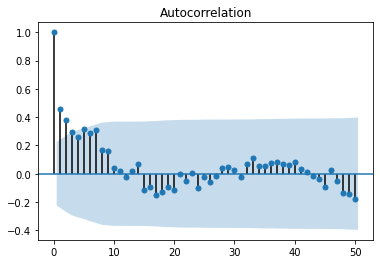

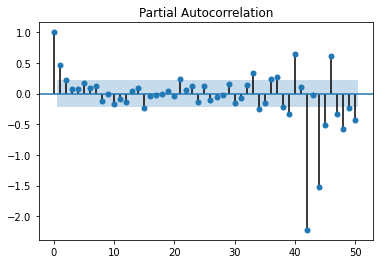

In [155]:
plot_acf(dff['Alemania'], lags=50);
plot_pacf(dff['Alemania'], lags=50);

## Estacionareidad


In [156]:
d_ff = adfuller(dff['Alemania'])
print('ADF Statistic: %f' % d_ff[0])
print('p-value: %f' % d_ff[1])

ADF Statistic: -5.207507
p-value: 0.000008


# Estimación de modelo

In [157]:
# fit model
model = ARIMA(dff['Alemania'], order=(2,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                              ARMA Model Results                              
Dep. Variable:               Alemania   No. Observations:                   76
Model:                     ARMA(2, 2)   Log Likelihood                -822.516
Method:                       css-mle   S.D. of innovations          12064.608
Date:                Mon, 22 Jun 2020   AIC                           1657.033
Time:                        23:06:47   BIC                           1671.017
Sample:                    01-01-2014   HQIC                          1662.622
                         - 04-01-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.685e+04   4871.115      5.511      0.000    1.73e+04    3.64e+04
ar.L1.Alemania     0.0070      0.124      0.057      0.955      -0.236       0.250
ar.L2.Alemania     0.8223      0.102

## Comentario:

Es posible visualizar que la estructura que siguen los datos es la de un ARMA (2,2), apesar de que los primeros resagos no se muestren significantes. Lo anterior con base en el sustento gráfico del autocorrelograma y el autocorrelograma parcial.

## Gráfico de residuales

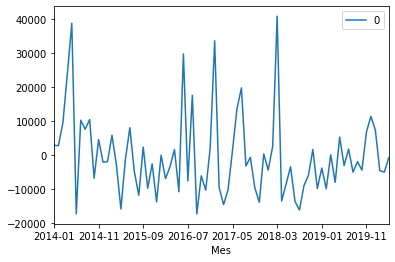

In [158]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

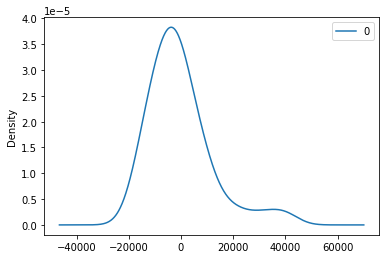

                  0
count     76.000000
mean    -355.074142
std    12195.606238
min   -17418.673941
25%    -8762.209616
50%    -2825.571782
75%     3227.302372
max    40883.093812


In [159]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Prueba de normalidad

In [160]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print('Estadístico=%.3f, p=%.3f' % (stat, p_value))

alpha = 0.05

if p_value > alpha:
    print('No rechazamos la hipótesis nula')
else:
    print('Rechazamos la hipótesis nula')

Estadístico=0.885, p=0.000
Rechazamos la hipótesis nula


## Rolling forecast

Estimación de parámetros para el mejor pronóstico de la serie: *fruta frescas en Alemania*

In [161]:
X = dff['Alemania'].values
p=np.arange(1,4,1)
q=np.arange(1,4,1)
d=np.arange(1,4,1)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
errors = list()
data = []
for m in range(len(p)):
    for n in range(len(q)):
        for o in range(len(d)):
            try:
                for t in range(len(test)):
                    model = ARIMA(history, order=(m,n,o))
                    model_fit = model.fit(disp=0)
                    output = model_fit.forecast()
                    yhat = output[0]
                    predictions.append(yhat)
                    obs = test[t]
                    history.append(obs)
                error = mean_squared_error(test, predictions) ** 0.5
                print(m,n,o,error)
                errors.append(error)
                data.append((m,n,o,error))
                predictions = list()
                history = [x for x in train]
            except:
                print('Error cuando se intenta la combinación '+str(m)+str(n)+str(o))
        
cols=['P','Q','D','error']
result = pd.DataFrame(data, columns=cols)

0 0 0 14403.982212020592
0 0 1 12730.510775197892
0 0 2 12580.98420629018
0 1 0 12848.621906578157
0 1 1 11538.428765312525
0 1 2 11461.692178885762
0 2 0 20987.30716076574
0 2 1 13145.7713476907
Error cuando se intenta la combinación 022
1 0 0 11925.246256816714
1 0 1 11347.77023521701
Error cuando se intenta la combinación 102
Error cuando se intenta la combinación 110
Error cuando se intenta la combinación 111


C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



Error cuando se intenta la combinación 112
Error cuando se intenta la combinación 120
Error cuando se intenta la combinación 121
Error cuando se intenta la combinación 122
Error cuando se intenta la combinación 200
Error cuando se intenta la combinación 201
Error cuando se intenta la combinación 202
Error cuando se intenta la combinación 210
Error cuando se intenta la combinación 211
Error cuando se intenta la combinación 212
Error cuando se intenta la combinación 220
Error cuando se intenta la combinación 221
Error cuando se intenta la combinación 222


In [162]:
result.sort_values('error')

,P,Q,D,error
9,1,0,1,11347.770235
5,0,1,2,11461.692179
4,0,1,1,11538.428765
8,1,0,0,11925.246257
2,0,0,2,12580.984206
1,0,0,1,12730.510775
3,0,1,0,12848.621907
7,0,2,1,13145.771348
0,0,0,0,14403.982212
6,0,2,0,20987.307161


In [163]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
errors = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions) ** 0.5
#print(m,l,error)
errors.append(error)
print(model_fit.summary())


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   75
Model:                     ARMA(1, 1)   Log Likelihood                -812.921
Method:                       css-mle   S.D. of innovations          12294.120
Date:                Mon, 22 Jun 2020   AIC                           1633.841
Time:                        23:08:10   BIC                           1643.111
Sample:                             0   HQIC                          1637.542
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.672e+04   4733.282      5.646      0.000    1.74e+04     3.6e+04
ar.L1.y        0.8988      0.090      9.942      0.000       0.722       1.076
ma.L1.y       -0.6375      0.163     -3.918      0.0

In [164]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions) **0.5
print('Test MSE: %.3f' % error)

Test MSE: 11347.770


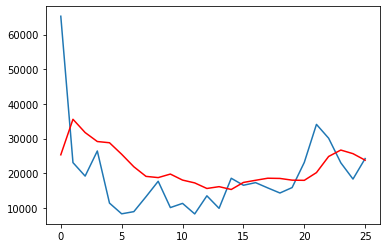

In [165]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


## Comentario

Como es posible observar en la gráfica y en la tabla de resultados anterior, apesar de que usamos el modelo con el menor MSE no obtenemos un buen pronóstico, por lo anterior, sería necesarío realizar una transformación a la serie o utilizar un modelo diferente al ARIMA

## Estimación de modelo:
### Libreria Prophet

In [182]:
dffp=df_ff[df_ff.Pais.isin(['Alemania'])].groupby(['Pais','Mes']).sum().reset_index().drop(columns = ['Pais'], axis = 1)
dffp=dffp.rename(columns={"Mes": "ds", "FOB": "y"})
print(len(dffp))
dffp.head()

76


,ds,PA,y
0,2014-01,19444868320,711739.98
1,2014-02,16201252300,616020.37
2,2014-03,18640675340,879166.05
3,2014-04,14579448280,996506.57
4,2014-05,18624282320,1761813.65


In [167]:
m = Prophet()
m.fit(dffp)
future = m.make_future_dataframe(periods = 6, freq = 'M')
forecast = m.predict(future)
forecast[['ds','yhat', 'yhat_lower','yhat_upper']].iloc[-10:]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
72,2020-01-01,333203.343215,-53657.796035,7.552383e+05
73,2020-02-01,422297.565498,41798.508186,8.164246e+05
74,2020-03-01,480299.804135,89174.031965,9.150988e+05
75,2020-04-01,477402.396375,119357.608047,8.783339e+05
76,2020-04-30,793776.543827,420441.148570,1.170025e+06
77,2020-05-31,409088.478952,19754.398006,7.890509e+05
78,2020-06-30,384670.745747,2995.962686,7.803270e+05
79,2020-07-31,139284.630451,-244774.912592,5.214165e+05
80,2020-08-31,432295.688936,67799.124071,8.419582e+05
81,2020-09-30,324215.072053,-94233.264790,7.175326e+05


In [168]:
# Sumarle un mes a las fechas sacadas con future después de hacer el forecast
forecast['ds'].iloc[-6:] =forecast['ds'].iloc[-6:] + timedelta(days=1)
forecast['ds'].iloc[-10:]

72   2020-01-01
73   2020-02-01
74   2020-03-01
75   2020-04-01
76   2020-05-01
77   2020-06-01
78   2020-07-01
79   2020-08-01
80   2020-09-01
81   2020-10-01
Name: ds, dtype: datetime64[ns]

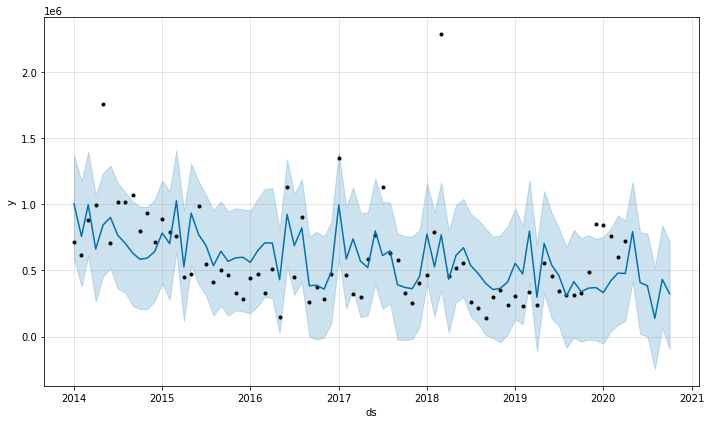

In [169]:
fig1 = m.plot(forecast)

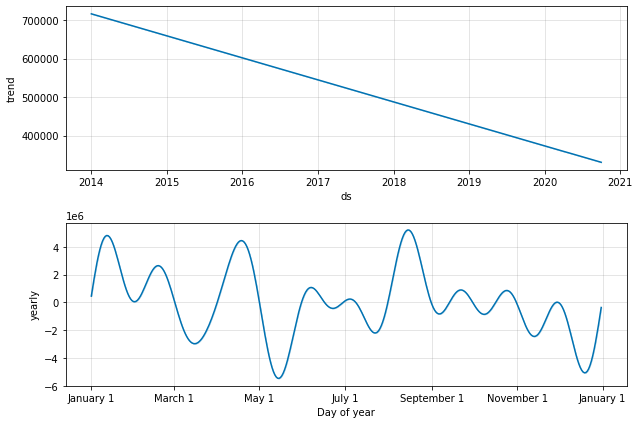

In [170]:
m.plot_components(forecast);

# Comentario:

Se observa que con la librería prophet ocurre algo similar que con ARIMA. Los modelos no se ajustan a la totalidad de la muestra de los datos y por lo tanto requieren un ajuste.

## Pronostico sobre muestra

In [184]:
dffp = dffp.drop(['PA'], axis =1)

In [185]:
X = dffp.values

In [187]:
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(df)]
test1 =pd.DataFrame(test)

In [188]:
test1.head()

,0,1
0,2019-09,313700
1,2019-10,332380
2,2019-11,484940
3,2019-12,851988
4,2020-01,842224


In [189]:
test1.columns = ['ds', 'y']
test1['ds'] = pd.to_datetime(test1['ds'])
train1 =pd.DataFrame(train)
train1.columns = ['ds', 'y']
train1['ds'] = pd.to_datetime(train1['ds'])
train1.head()

,ds,y
0,2014-01-01,711740
1,2014-02-01,616020
2,2014-03-01,879166
3,2014-04-01,996507
4,2014-05-01,1.76181e+06


In [190]:
prediccion = pd.DataFrame(columns = ['ds', 'yhat', 'yhat_lower','yhat_upper'])
for l in range(7):
    for t in range(len(test1)):
        model = Prophet(n_changepoints = 1)
        model_fit = model.fit(train1)
        future = model.make_future_dataframe(periods = l , freq = 'M')
        forecast = model.predict(future)
        forecast['ds'].iloc[-6:] =forecast['ds'].iloc[-6:] + timedelta(days=1)
        #print(len(forecast))
        obs = pd.DataFrame(test1[['ds','y']].iloc[:l])
prediccion = prediccion.append(forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']])

print(prediccion)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

           ds          yhat    yhat_lower    yhat_upper
0  2014-01-01  1.026391e+06  6.593323e+05  1.415833e+06
1  2014-02-01  7.933656e+05  4.118348e+05  1.169649e+06
2  2014-03-01  1.065038e+06  6.748927e+05  1.463732e+06
3  2014-04-01  7.101574e+05  3.548977e+05  1.102106e+06
4  2014-05-01  9.168502e+05  5.511848e+05  1.299166e+06
5  2014-06-01  9.729586e+05  5.918728e+05  1.382199e+06
6  2014-07-01  8.387456e+05  4.742950e+05  1.196410e+06
7  2014-08-01  7.809874e+05  4.280681e+05  1.185885e+06
8  2014-09-01  7.251748e+05  3.333121e+05  1.121208e+06
9  2014-10-01  6.650068e+05  2.649214e+05  1.055783e+06
10 2014-11-01  6.487804e+05  2.515267e+05  1.042092e+06
11 2014-12-01  5.917996e+05  1.885641e+05  9.926596e+05
12 2015-01-01  7.157596e+05  3.277067e+05  1.097772e+06
13 2015-02-01  6.790760e+05  2.892099e+05  1.070948e+06
14 2015-03-01  1.125699e+06  7.286952e+05  1.515288e+06
15 2015-04-01  6.025487e+05  2.272069e+05  1.000062e+06
16 2015-05-01  9.456313e+05  5.554419e+05  1.325

In [191]:
prediccion

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-01,1.026391e+06,6.593323e+05,1.415833e+06
1,2014-02-01,7.933656e+05,4.118348e+05,1.169649e+06
2,2014-03-01,1.065038e+06,6.748927e+05,1.463732e+06
3,2014-04-01,7.101574e+05,3.548977e+05,1.102106e+06
4,2014-05-01,9.168502e+05,5.511848e+05,1.299166e+06
5,2014-06-01,9.729586e+05,5.918728e+05,1.382199e+06
6,2014-07-01,8.387456e+05,4.742950e+05,1.196410e+06
7,2014-08-01,7.809874e+05,4.280681e+05,1.185885e+06
8,2014-09-01,7.251748e+05,3.333121e+05,1.121208e+06
9,2014-10-01,6.650068e+05,2.649214e+05,1.055783e+06


In [192]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test1['y'], prediccion['yhat'].iloc[-8:]) **0.5
print('Test MSE: %.3f' % error)

Test MSE: 636022.562


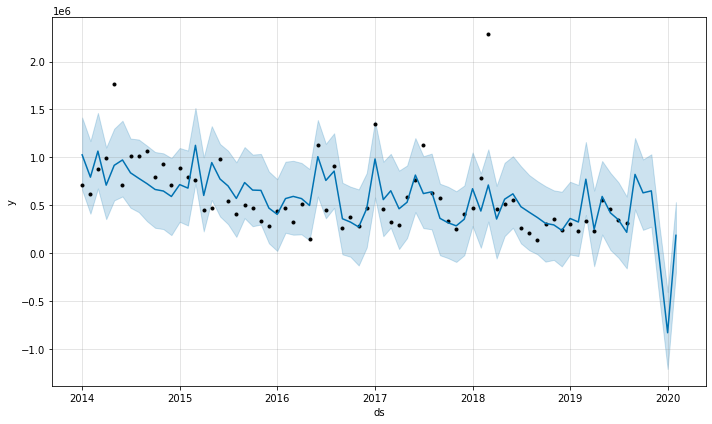

In [193]:
fig2 = model.plot(prediccion)

## Comentario:

Es posible observar que para las últimas observaciones que se tienen del modelo la aproximación de los puntos es bastante cercana. Por lo anterior, es posible pensar que el ejercicio sobre muestra puede ser una buena forma para pronosticar si el comportamiento de la serie no ha presentado algún choque que modifique su estructura original.

## Tranformación logarítmica de la serie

Dados los resultados no tan satisfactorios para la serie original, se decide realizar un ejercicio a partir de la transfimación de la serie. Dicha transformación, además de permitir tener la misma seria pero de forma diferente, trae algunos beneficios adicionales, como el ajuste de la varianza (en caso de de que esta fuese un problema).

In [194]:
dff_lg=dff
dff_lg['Alemania_log']=np.log(dff_lg['Alemania'])
dff_lg.head()

Pais,Alemania,Hong Kong,Alemania_log
Mes,,,
2014-01,29655.832500,3382.056000,10.297414
2014-02,30801.018500,11438.650000,10.335303
2014-03,38224.610870,27832.976667,10.551235
2014-04,55361.476111,26133.076000,10.921639
2014-05,76600.593478,7151.946667,11.246360


## Evaluación del comportamiento de la serie

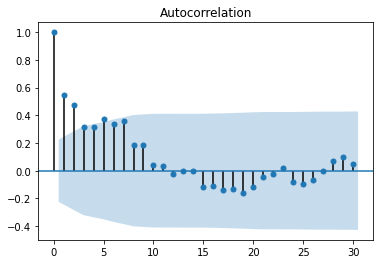

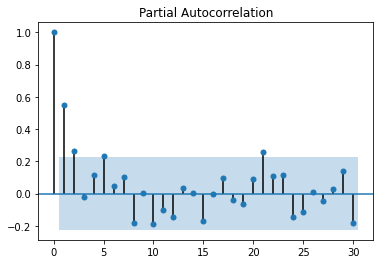

In [195]:
plot_acf(dff_lg['Alemania_log'], lags=30);
plot_pacf(dff_lg['Alemania_log'], lags=30);

In [196]:
d_ff_lg = adfuller(dff_lg['Alemania_log'])
print('ADF Statistic: %f' % d_ff_lg[0])
print('p-value: %f' % d_ff_lg[1])

ADF Statistic: -3.128120
p-value: 0.024541


In [197]:
d_ff_lg = adfuller(dff_lg['Alemania_log'].diff().iloc[1:])
print('ADF Statistic: %f' % d_ff_lg[0])
print('p-value: %f' % d_ff_lg[1])

ADF Statistic: -7.570338
p-value: 0.000000


In [198]:
# fit model
model_log = ARIMA(dff_lg['Alemania_log'], order=(2,1,0))
model_lg_fit = model_log.fit(disp=0)
print(model_lg_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Alemania_log   No. Observations:                   75
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -46.785
Method:                       css-mle   S.D. of innovations              0.451
Date:                Mon, 22 Jun 2020   AIC                            101.570
Time:                        23:20:14   BIC                            110.840
Sample:                    02-01-2014   HQIC                           105.272
                         - 04-01-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0043      0.033     -0.129      0.898      -0.070       0.061
ar.L1.D.Alemania_log    -0.4663      0.114     -4.082      0.000      -0.690      -0.242
ar.L2.D.Alem

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### Gráfica de los errores

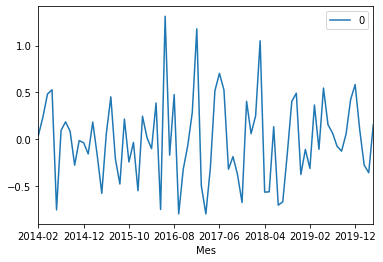

In [199]:
# plot residual errors
residuals_log = pd.DataFrame(model_lg_fit.resid)
residuals_log.plot()
plt.show()

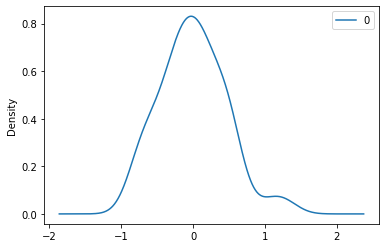

               0
count  75.000000
mean    0.000605
std     0.453913
min    -0.801412
25%    -0.311458
50%    -0.017028
75%     0.266277
max     1.314204


In [200]:
residuals_log.plot(kind='kde')
plt.show()
print(residuals_log.describe())

In [201]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print('Estadístico=%.3f, p=%.3f' % (stat, p_value))

alpha = 0.05

if p_value > alpha:
    print('No rechazamos la hipótesis nula')
else:
    print('Rechazamos la hipótesis nula')

Estadístico=0.885, p=0.000
Rechazamos la hipótesis nula


## Rolling Forecast: 

Estimación de parámetros para el mejor pronóstico de la serie: *frutas frescas en Alemania (logarítmica)*

In [202]:
X = dff_lg['Alemania_log'].values
p=np.arange(1,4,1)
q=np.arange(1,4,1)
d=np.arange(1,4,1)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
errors = list()
data = []
for m in range(len(p)):
    for n in range(len(q)):
        for o in range(len(d)):
            try:
                for t in range(len(test)):
                    model = ARIMA(history, order=(m,n,o))
                    model_fit = model.fit(disp=0)
                    output = model_fit.forecast()
                    yhat = output[0]
                    predictions.append(yhat)
                    obs = test[t]
                    history.append(obs)
                error = mean_squared_error(test, predictions) ** 0.5
                print(m,n,o,error)
                errors.append(error)
                data.append((m,n,o,error))
                predictions = list()
                history = [x for x in train]
            except:
                print('Error cuando se intenta la combinación '+str(m)+str(n)+str(o))
        
cols=['P','Q','D','error']
result = pd.DataFrame(data, columns=cols)

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0 0 0 0.6039703194198274
0 0 1 0.5090611413725865
0 0 2 0.47464313830006066
0 1 0 0.438084013302808


C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0 1 1 0.44678952782895665
0 1 2 0.4436138885695759
0 2 0 0.6890557508817855
0 2 1 0.4481088764476239
Error cuando se intenta la convinación 022
1 0 0 0.44471888660031333
1 0 1 0.4358633556118619
1 0 2 0.45003795737216146
1 1 0 0.4397479630189478
1 1 1 0.440221565645523
Error cuando se intenta la convinación 112
Error cuando se intenta la convinación 120


C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Error cuando se intenta la convinación 121
Error cuando se intenta la convinación 122
Error cuando se intenta la convinación 200
Error cuando se intenta la convinación 201


C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Usuario

Error cuando se intenta la convinación 202
Error cuando se intenta la convinación 210
Error cuando se intenta la convinación 211


C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Usuario\Anaconda3\lib\s

Error cuando se intenta la convinación 212
Error cuando se intenta la convinación 220
Error cuando se intenta la convinación 221
Error cuando se intenta la convinación 222


In [203]:
result.sort_values('error')

,P,Q,D,error
9,1,0,1,0.435863
3,0,1,0,0.438084
11,1,1,0,0.439748
12,1,1,1,0.440222
5,0,1,2,0.443614
8,1,0,0,0.444719
4,0,1,1,0.446790
7,0,2,1,0.448109
10,1,0,2,0.450038
2,0,0,2,0.474643


In [204]:
X = dff_lg['Alemania_log'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
errors = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions) ** 0.5
#print(m,l,error)
errors.append(error)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   75
Model:                     ARMA(1, 1)   Log Likelihood                 -42.444
Method:                       css-mle   S.D. of innovations              0.425
Date:                Mon, 22 Jun 2020   AIC                             92.888
Time:                        23:22:20   BIC                            102.158
Sample:                             0   HQIC                            96.589
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0550      0.172     58.292      0.000       9.717      10.393
ar.L1.y        0.8731      0.102      8.586      0.000       0.674       1.072
ma.L1.y       -0.5268      0.196     -2.689      0.0

In [205]:
error = mean_squared_error(test, predictions) **0.5
print('Test MSE: %.3f' % error)

Test MSE: 0.436


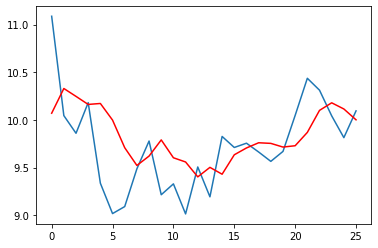

In [206]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Comentario 

Es posible concluir que a pesar de que las magnitudes de las series sean diferentess gracias a la transformación logarítmica, el comportamiento del pronóstico es el mismo. Por lo tanto, podriamos decir que la comparación de la serie mediante los logaritmicos no son diferentes a los valores netos, para intentar cambiar eso sería necesario retornas los pronósticos a los valores netos


## Estimación de modelo:
### Libreria Prophet

In [207]:
dffp_lg=df_ff[df_ff.Pais.isin(['Alemania'])].groupby(['Pais','Mes']).sum().reset_index().drop(columns = ['Pais'], axis = 1)
dffp_lg=dffp_lg.rename(columns={"Mes": "ds", "FOB": "y"})
dffp_lg['y']=np.log(dffp_lg['y'])
print(len(dffp_lg))
dffp_lg.head()

76


,ds,PA,y
0,2014-01,19444868320,13.475468
1,2014-02,16201252300,13.331035
2,2014-03,18640675340,13.686729
3,2014-04,14579448280,13.812011
4,2014-05,18624282320,14.381854


In [208]:
m = Prophet()
m.fit(dffp_lg)
future = m.make_future_dataframe(periods = 6, freq = 'M')
forecast = m.predict(future)
forecast[['ds','yhat', 'yhat_lower','yhat_upper']].iloc[-10:]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
72,2020-01-01,13.038079,12.508490,13.563229
73,2020-02-01,13.121238,12.605523,13.584813
74,2020-03-01,13.126021,12.616726,13.644941
75,2020-04-01,13.307905,12.777361,13.771990
76,2020-04-30,13.945857,13.404033,14.446936
77,2020-05-31,13.287315,12.788190,13.798662
78,2020-06-30,13.162481,12.638182,13.687557
79,2020-07-31,12.732223,12.237132,13.203973
80,2020-08-31,13.302735,12.749914,13.806181
81,2020-09-30,13.255265,12.718945,13.748900


In [209]:
forecast['ds'].iloc[-6:] =forecast['ds'].iloc[-6:] + timedelta(days=1)
forecast['ds'].iloc[-10:]

72   2020-01-01
73   2020-02-01
74   2020-03-01
75   2020-04-01
76   2020-05-01
77   2020-06-01
78   2020-07-01
79   2020-08-01
80   2020-09-01
81   2020-10-01
Name: ds, dtype: datetime64[ns]

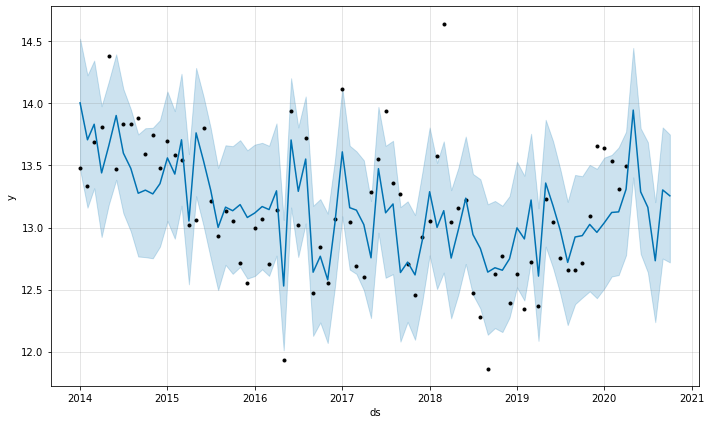

In [210]:
fig1 = m.plot(forecast)

## Comentario 

El pronóstico resultante de la librería Prophet en la transformación logarítmica logra aproximarse mása a unos valores que en los valores netos a la vez que se aleja de otros. Es decir, los pronósticos resultantes tienen el mismo comportamiento y se hace más evidente la necesidad de retornar los pronósticos logartimos a su valor neto para comparar.

## Pronóstico sobre muestra

In [212]:
dffp_lg = dffp_lg.drop(['PA'],axis = 1)

In [213]:
X = dffp_lg.values

size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(df)]
test1 =pd.DataFrame(test)
test1.columns = ['ds', 'y']
test1['ds'] = pd.to_datetime(test1['ds'])
train1 =pd.DataFrame(train)
train1.columns = ['ds', 'y']
train1['ds'] = pd.to_datetime(train1['ds'])
train1.head()

,ds,y
0,2014-01-01,13.4755
1,2014-02-01,13.331
2,2014-03-01,13.6867
3,2014-04-01,13.812
4,2014-05-01,14.3819


In [214]:
prediccion = pd.DataFrame(columns = ['ds', 'yhat', 'yhat_lower','yhat_upper'])
for l in range(7):
    for t in range(len(test1)):
        model = Prophet(n_changepoints = 1)
        model_fit = model.fit(train1)
        future = model.make_future_dataframe(periods = l , freq = 'M')
        forecast = model.predict(future)
        forecast['ds'].iloc[-6:] =forecast['ds'].iloc[-6:] + timedelta(days=1)
        #print(len(forecast))
        obs = pd.DataFrame(test1[['ds','y']].iloc[:l])
prediccion = prediccion.append(forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']])

print(prediccion)

        #train1 = train1.append(obs, ignore_index = True)
        #prediccion = prediccion.append(forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']])
        #yhat =pd.DataFrame(forecast[['yhat'][-1:]])
        #predictions.append(yhat)
        

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

           ds       yhat  yhat_lower  yhat_upper
0  2014-01-01  13.894586   13.372145   14.426194
1  2014-02-01  13.625078   13.090200   14.093334
2  2014-03-01  13.796391   13.283037   14.324188
3  2014-04-01  13.408782   12.901214   13.907121
4  2014-05-01  13.654675   13.156135   14.183789
5  2014-06-01  13.906459   13.396664   14.423057
6  2014-07-01  13.614972   13.127525   14.102342
7  2014-08-01  13.509781   13.004753   14.016100
8  2014-09-01  13.322611   12.827904   13.845235
9  2014-10-01  13.364333   12.837598   13.910476
10 2014-11-01  13.275377   12.769044   13.807990
11 2014-12-01  13.183063   12.631440   13.713428
12 2015-01-01  13.444875   12.934008   13.943201
13 2015-02-01  13.372094   12.862924   13.847274
14 2015-03-01  13.852841   13.376920   14.384762
15 2015-04-01  13.146130   12.651257   13.648553
16 2015-05-01  13.792296   13.262724   14.321953
17 2015-06-01  13.558097   13.041799   14.074692
18 2015-07-01  13.342371   12.803444   13.837445
19 2015-08-01  13.09

In [215]:
prediccion

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-01,13.894586,13.372145,14.426194
1,2014-02-01,13.625078,13.090200,14.093334
2,2014-03-01,13.796391,13.283037,14.324188
3,2014-04-01,13.408782,12.901214,13.907121
4,2014-05-01,13.654675,13.156135,14.183789
5,2014-06-01,13.906459,13.396664,14.423057
6,2014-07-01,13.614972,13.127525,14.102342
7,2014-08-01,13.509781,13.004753,14.016100
8,2014-09-01,13.322611,12.827904,13.845235
9,2014-10-01,13.364333,12.837598,13.910476


In [216]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test1['y'], prediccion['yhat'].iloc[-8:]) **0.5
print('Test MSE: %.3f' % error)

Test MSE: 1.116


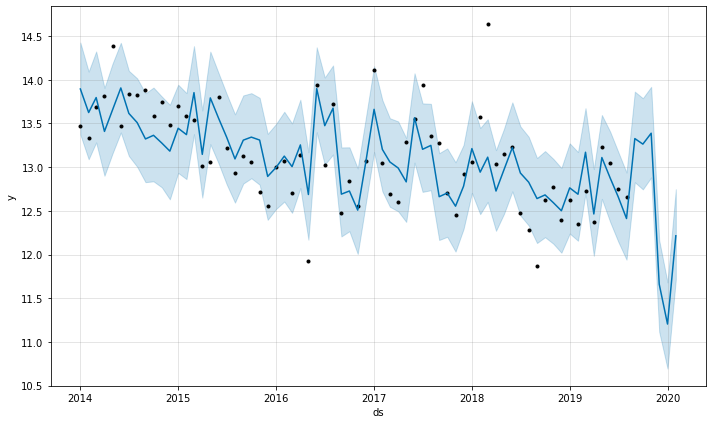

In [217]:
fig2 = model.plot(prediccion)

## Inversión de la serie transformada

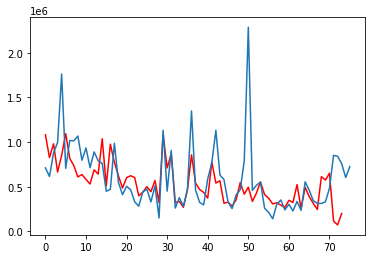

In [218]:
plt.plot(np.exp(prediccion['yhat']), color='red')
plt.plot(np.exp(dffp_lg['y']))
plt.show()

## Conclusión

Mediante la transformación logarítmica de la serie, es posible observar que los pronósticos realizados sobre la muestra se aproximan mucho mejor a los datos realmente observados. A su vez, se evidencia la necesidad comentada en puntos anteriores de realizar el inverso de la serie logaritmica para obtener los valores reales.

Por otro lado, se puede ver que existe un valor que puede ser considerado como un salto, lo cual requiere la aplicación de un cambio estructural en la serie o un drift para que se pueda acercar de mejor forma a su valor real.  


# Conclusiones generales:

Los resultados de los modelos de series de tiempo estimados permiten hacer pronósticos robustos sobre los logaritmos del valor total de las exportaciones del país.

Este tipo de modelamientos puede ser útil para hacer un monitoreo permanente de los ingresos tributarios que percibe la nación y su comportamiento en relación con las exportaciones del país. En este sentido, futuros desarrollos de este tipo de modelos pueden ser útiles para las autoridades aduaneras.